# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
1.0     | 03/10/2022 | H.A.       | Compilation of Dataviz jupyter notebooks from H.A 

This notebook 


*   loads the raw data donwloaded from the ASRS in to a pandas DataFrame (total of `108241` entries)
*   removes 2 columns named 'Unnammed: ...' that originate from the concatenation of several .csv files into the `ASRS_20y_data.csv` file
* builds a data dictionary including 
  - Data categories, types
  - UAS features flag
* cleans data from UAS entries / columns
* provides Data Exploration metrics
* provides Explorations of textual data

# IMPORT PACKAGES


In [1]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns

import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import itertools # Pour créer des iterateurs

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
# plt.rcParams['axes.titlesize'] = 30
# plt.rcParams['axes.labelsize'] = 23
# plt.rcParams['xtick.labelsize'] = 23
# plt.rcParams['ytick.labelsize'] = 23
# plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool


from time import time
#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import RegexpTokenizer


# Importation des packages nécessaires pour la CAH
from sklearn.cluster import AgglomerativeClustering , KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# FUNCTION DEFINITIONS

In [2]:
def plot_word_cloud(text, title, stop_words, mask, background_color = "white") :
    """
    Plot a wordcloud of the input variable 'text' using the mask 'mask' and with 'title' as title .
    """
    from wordcloud import WordCloud
    from PIL import Image 
    # PIL: Python Imaging Library. Adds image processing capabilities to your Python interpreter.

    # Define a mask
    mask_coloring = np.array(Image.open(str(mask)))

    # Define the word cloud layer
    wc = WordCloud(background_color=background_color, 
                   max_words=150, 
                   stopwords=stop_words, 
                   mask = mask_coloring,
                   colormap='ocean', # cool # winter # ocean
                   # see list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
                   max_font_size=40, random_state=42)
    
    # Generate and plot the wordcloud
    #plt.figure(figsize= (10,5)) # comment it out if you use subplots
    wc.generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{title}", fontsize = 15)
    #plt.show() # comment it out if you use subplots

# LOAD DATA

## Mount GDrive

In [3]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [4]:
# move to the desired location (adapt to your folder-tree-structure):
%cd /content/drive/MyDrive/data/

/content/drive/MyDrive/data


In [5]:
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 ASRS_20y_data.csv			 plane.png
'Data Dictionary categories.csv'	'saved models'
 min_df_results				 State_Reference_Dictionary.csv
'_old_Data Dictionnary categories.csv'	 transformed


## Load the ASRS_20y_data.csv data




In [6]:
df = pd.read_csv('ASRS_20y_data.csv', low_memory=False,index_col=1)
# See https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

In [7]:
print("A total of", len(df), "entries have been loaded.")

A total of 108407 entries have been loaded.


In [8]:
df.columns

Index(['Unnamed: 0', 'Date', 'Local Time Of Day', 'Locale Reference',
       'State Reference', 'Relative Position.Angle.Radial',
       'Relative Position.Distance.Nautical Miles',
       'Altitude.AGL.Single Value', 'Altitude.MSL.Single Value',
       'Latitude / Longitude (UAS)',
       ...
       'When Detected', 'Result', 'Contributing Factors / Situations',
       'Primary Problem', 'Narrative', 'Callback', 'Narrative.1', 'Callback.1',
       'Synopsis', 'Unnamed: 125'],
      dtype='object', length=126)

In [9]:
df.shape

(108407, 126)

## Index sanity check (unicity - completion)

In [10]:
# Sanity check : OK
# Validation of unicity and completion of ACN (report ID) : 
# as data originates from repeted extractions of ASRS database, this ensures that no report was imported twice
ACN_duplicates=df.index.duplicated().sum()
ACN_Nan=df.index.isnull().sum(axis = 0) 
print(ACN_duplicates,' duplicates in the index column (expected=0)') 
print(ACN_Nan, 'Nan in the index column (expected=0)')

if ACN_Nan==0 and ACN_Nan==0 :
  print ('ID OK : No duplicates & No Nan')
else : 
  print ('ID KO : Duplicates Or Nan')


0  duplicates in the index column (expected=0)
0 Nan in the index column (expected=0)
ID OK : No duplicates & No Nan


## First data cleaning : remove empty columns

In [11]:
# Remove Unnamed columns
df = df.drop(['Unnamed: 0','Unnamed: 125'], axis = 1)    
df.shape

(108407, 124)

## Load the State Reference data 

In [12]:
# Dictionary for State Reference 
# Csv file import 
Stat_Reference_df=pd.read_csv('State_Reference_Dictionary.csv',sep=';')
Stat_Reference_df.head()

State Reference    State Type      State Name
0              AL      US State         ALABAMA
1              AK      US State          ALASKA
2              AS  US Territory  AMERICAN SAMOA
3              AZ      US State        ARIZONA 
4              AR      US State        ARKANSAS

In [13]:
Stat_Reference_df.shape

(82, 3)

# DATA Dictionary

## Load the 'Data Dictionary categories.csv' : Features & categories

In [14]:
DF_Dictionary=pd.read_csv('Data Dictionary categories.csv',sep=';')
DF_Dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  125 non-null    object
 1   Column    125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [15]:
DF_Dictionary

Category                                             Column
0             ID                                                ACN
1           Time                                               Date
2           Time                                  Local Time Of Day
3          Place                                   Locale Reference
4          Place                                    State Reference
5          Place                     Relative Position.Angle.Radial
6          Place          Relative Position.Distance.Nautical Miles
7          Place                          Altitude.AGL.Single Value
8          Place                          Altitude.MSL.Single Value
9          Place                         Latitude / Longitude (UAS)
10   Environment                                  Flight Conditions
11   Environment                      Weather Elements / Visibility
12   Environment                            Work Environment Factor
13   Environment                                              Light
14   Environment                                            Ceiling
15   Environment                                   RVR.Single Value
16    Aircraft 1                                     ATC / Advisory
17    Aircraft 1                                  Aircraft Operator
18    Aircraft 1                                    Make Model Name
19    Aircraft 1                                      Aircraft Zone
20    Aircraft 1                                          Crew Size
21    Aircraft 1                           Operating Under FAR Part
22    Aircraft 1                                        Flight Plan
23    Aircraft 1                                            Mission
24    Aircraft 1                                         Nav In Use
25    Aircraft 1                                       Flight Phase
26    Aircraft 1                                       Route In Use
27    Aircraft 1                                           Airspace
28    Aircraft 1            Maintenance Status.Maintenance Deferred
29    Aircraft 1                Maintenance Status.Records Complete
30    Aircraft 1            Maintenance Status.Released For Service
31    Aircraft 1  Maintenance Status.Required / Correct Doc On B...
32    Aircraft 1                Maintenance Status.Maintenance Type
33    Aircraft 1      Maintenance Status.Maintenance Items Involved
34    Aircraft 1                                     Cabin Lighting
35    Aircraft 1                             Number Of Seats.Number
36    Aircraft 1                         Passengers On Board.Number
37    Aircraft 1          Crew Size Flight Attendant.Number Of Crew
38    Aircraft 1              Airspace Authorization Provider (UAS)
39    Aircraft 1  Operating Under Waivers / Exemptions / Authori...
40    Aircraft 1        Waivers / Exemptions / Authorizations (UAS)
41    Aircraft 1                  Airworthiness Certification (UAS)
42    Aircraft 1                              Weight Category (UAS)
43    Aircraft 1                                Configuration (UAS)
44    Aircraft 1                           Flight Operated As (UAS)
45    Aircraft 1         Flight Operated with Visual Observer (UAS)
46    Aircraft 1                                 Control Mode (UAS)
47    Aircraft 1                      Flying In / Near / Over (UAS)
48    Aircraft 1                            Passenger Capable (UAS)
49    Aircraft 1                                         Type (UAS)
50    Aircraft 1               Number of UAS Being Controlled (UAS)
51     Component                                 Aircraft Component
52     Component                                       Manufacturer
53     Component                                 Aircraft Reference
54     Component                                            Problem
55    Aircraft 2                                   ATC / Advisory.1
56    Aircraft 2                                Aircraft Operator.1
57    Aircraft 2                                  Make Model Nam

In [16]:
# Data Raw Types
DF_Types=pd.DataFrame(df.dtypes).reset_index() 
DF_Types=DF_Types.rename({'index':'Column', 0:'Type'}, axis = 1)
DF_Dictionary=DF_Dictionary.merge(right=DF_Types, on = ['Column'], how='inner')
DF_Dictionary.head(10)

Category                                     Column     Type
0         Time                                       Date    int64
1         Time                          Local Time Of Day   object
2        Place                           Locale Reference   object
3        Place                            State Reference   object
4        Place             Relative Position.Angle.Radial  float64
5        Place  Relative Position.Distance.Nautical Miles  float64
6        Place                  Altitude.AGL.Single Value   object
7        Place                  Altitude.MSL.Single Value  float64
8        Place                 Latitude / Longitude (UAS)  float64
9  Environment                          Flight Conditions   object

## Defines the UAS features flag

In [17]:
# UAS feature : boolean - True if column name contains "UAS"
DF_Dictionary['UAS feature']=DF_Dictionary['Column'].astype('str').apply(lambda x: True if ('UAS' in x) else False)
DF_Dictionary.head(10)

Category                                     Column     Type  \
0         Time                                       Date    int64   
1         Time                          Local Time Of Day   object   
2        Place                           Locale Reference   object   
3        Place                            State Reference   object   
4        Place             Relative Position.Angle.Radial  float64   
5        Place  Relative Position.Distance.Nautical Miles  float64   
6        Place                  Altitude.AGL.Single Value   object   
7        Place                  Altitude.MSL.Single Value  float64   
8        Place                 Latitude / Longitude (UAS)  float64   
9  Environment                          Flight Conditions   object   

   UAS feature  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6        False  
7        False  
8         True  
9        False

# DATA CLEANING

### Drop UAS entries

# Hicheme's Macrofeatures pooling and plotting
- Focus on (Detector, Function, Experience and Function) macro features

## Detector

In [25]:
detector = {'Automation' :[],
            'Person' : [],
            'else' : []} # I add other to see if I have some 
                          # other values than 'Automation' and
                          # 'Person' in my Serrie

In [26]:
df_detector = df['Detector'].dropna()

In [27]:
for title in df_detector:
    if 'Automation' in title:
        detector['Automation'].append(title)
    elif 'Person' in title:
        detector['Person'].append(title)
    else:
        detector['else'].append(title)

In [28]:
for title in df_detector:
    if 'Automation' in title:
        df_detector = df_detector.replace(to_replace = title, value = 'Automation')
    elif 'Person' in title:
        df_detector = df_detector.replace(to_replace = title, value = 'Person')
    else:
        df_detector = df_detector.replace(to_replace = title, value = 'Else')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


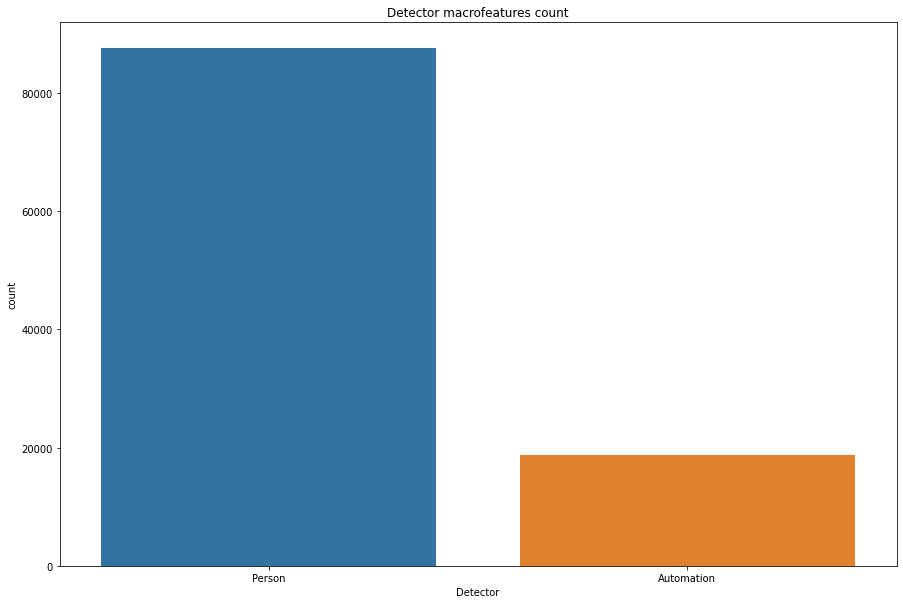

In [29]:
plt.figure(figsize =(15,10))
plt.title('Detector macrofeatures count')
plt.rc('font', size=32)
plt.rc('axes', titlesize=32)
sns.countplot(df_detector);

## Function

In [30]:
df_function = df['Function'].str.split('; ', expand =True).stack().reset_index(
    drop=True)

In [31]:
df_function = df_function.apply(lambda x:x.replace(' / ', '/'))

In [32]:
function = {'Flight Crew' :[],
            'Air Traffic Control' : [],
            'Maintenance' :[],
            'Flight Attendant' :[],
            'Dispatch': [],
            'Ground Personnel':[],
            'other' : [],
            'trainee':[],
            'else': []} # I add other to see if I have some 
                          # other values than 'Automation' and
                          # 'Person' in my Serrie

In [50]:
flight_crew_unique = ['Captain', 'Check Pilot','First Officer',
                     'Flight Engineer/Second Officer','Instructor',
                     'Pilot Flying','Pilot Not Flying','Relief Pilot',
                     'Single Pilot']

air_traffic_control_unique = ['Approach','Coordinator','Departure',
                             'Enroute','Flight Data/Clearance Delivery',
                             'Flight Service','Ground','Handoff/Assist',
                             'Instructor','Trainee','Local','Oceanic',
                             'Supervisor/CIC', 'Traffic Management']

maintenance_unique = ['Inspector', 'Instructor','Lead Technician',
              'Parts/Stores Personnel','Quality Assurance/Audit',
              'Technician'] #you don't know which 
                            #trainee we talk about

flight_attendant_unique =['Flight Attendant In Charge',
                          'Flight Attendant (On Duty)',
                          'Off Duty']

dispatch_unique = 'Dispatcher'
trainee_unique ='Trainee'

ground_personnel_unique = ['Airport Personnel','FBO Personnel',
                   'Gate Agent/CSR','Ramp', 'Vehicle Driver']
other_unique = ['Observer', 'Passenger', 'Other', 'Other/Unknown']

Else = ['Safety Pilot','skydiver','Unicom Operations','Safety Manager','Safety Analyst','SAFETY MANAGER',
 'DPE','Safety Analyst','SMS Analyst','Safety Ananlyst','Operations Manager','Safety Officer','Drone Operator',
 'Jet bridge Operator','With DPE','Local Civilian','student pilot & instr','Company CEO',
 'Safety Analyst','Safety Analyst','CFII was present','Solo Student','Student','Student','Lineman',
 'FSDO POI','Dual instruction flight','Commercial student','Instrument Student','PIC','DPE',
 'Supervisor of Flying','observer','Safety Analyst','Student Pilot','Maintenance Manager','Line Check Airman/Captain',
 'Safety Analyst','Unknown','ARMY H-60 CREW','Safety Analyst','Load Ccontroller','ATC','Load Planner',
 'Medical Crew','Load Planner',
 'Load Planner','Manager Saftey','Ground Vehicle Passenger','CHIEF INSPECTOR','Maintenance Controller',
 'Maintenance Controller','Manager','Maintenance Controller','Maintenance Manager','Maintenance Controller',
 'Maintence Controller','Maintenance Manager','Maintenance Controller','Deadheading Pilot',
 'Maintenance Controller','Maintenance Control','Retired Controller','Ground Crew','Maint Control',
 'Safety Rep','Maint Ctlr','Maint Controller','Maint Control','Chief Pilot','Builder','Maint Ctlr',
 'Maint Ctlr','Maint Ctlr','Maint Controller','Director of Maint','Maint Ctlr','Maint Ctlr','Maint Controller',
 'Inspection','Maint Supvr','MAINT. CONTROL','Maint Ctlr','Maint Ctlr','Maint Controller','MAINT CONTROLLER',
 'Maint Controller','MX CONTROLLER','MX MANAGER','Maint Controller','M/X CONTRLLR','Maint Controller',
 'Maint Controller', 'Maint Controller', 'Maint Controller','Maint Planner','MX CNTRLLR','M/X CNTROLLER',
 'Repairman','Maint Controller','Maintenance Controller','Mechanic Helper','Director of Maintenance',
 'Pilot','Maint Controller','Maint Ctlr','MANAGER MAINT CONTROL','Ramp Controller','Quality Control',
 'compliance director','Quality Manager','Ctlr','Flight Crew','Arpt Lineman','Parts Room','Deadheading Capt',
 'Cheif Flight Instructor','Maint Controller','Owner FBO','Tech Engineer','Maint Ctl','Maint Control',
 'Maint Controller','Maint Control','Dead Heading Crew Member', 'Maint Control','Deadhead',
 'Maint Controller','Maint Controller','Safety Personnel','Aviation Director','UAV Operator',
 'Other Crewmember', 'Dead Head','Load Planner','CIC','Traffic Watch','Tow Operator','Banner Tow',
 'CIC','In Flt Svc','Plt Examiner','Fueler','Maint Controller','Maint Ctlr','Maint Ctlr','Director Of Operations',
 'Maint Ctlr','Parts Planner','Acft Washer','Fueler','Maint Planner','Systems Engineer','Maint Ctlr',
 'Stock Clerk','Lead Inspector','Certificate Holder','Maint Ctlr','Check Airman','Director Of Maint',
 'Cabin Cleaner','Air Carrier Inspector','Air Carrier Inspector','Safety Officer','Attending Convention',
 'Systems Engr','CSR','Load Planner','Cabin Deadhead','Deadheading Plt','Baggage Handler','Deadheading',
 'Safety Pilot','DESIGNATED PILOT EXAMINER','sales','Air Carrier Inspector','Safety Plt',
 'Flight Safety Manager','Maint Ctlr','Maint Ctlr','Maint Planner','Maint Controller',
 'Maint Controller','Parts Coordinator','Assistant Chief Pilot','Cleaner','Owner','Owner',
 'Maintenance Director','Maint Ctl','Owner','Stores Clerk','Maint Ctlr','Manager','Air Carrier Inspector',
 'Auditor','Air Carrier Inspector','Manager','Maint Coordinator','Stores Supervisor','Maint Controller',
 'Owner/Pilot','Maint Ctlr','Engineering Manager','Maint Ctlr','Maint Ctlr','Air Carrier Inspector',
 'Maint Ctlr','Safety Plt','Maint Ctlr','MAINT CTLR','MAINT CTLR','ACFT OWNER','MAINT CTLR',
 'MANAGER','Shop Supervisor','Owner','Maint Ctlr','Maint Ctlr','Ramp Cleaner','MAINT CTLR',
 'Maint Planner','Maint Ctlr','Maintenance Controller','Quality Control Inspector',
 'Maintenance Controller','Maintenance Controller','Maint Ctlr','Lead Inspector','Maint Ctlr','Lead Inspector',
 'Maint Ctlr','Crew Chief','Acft Cleaner','Maint Ctlr','Stock Clerk','Wing Walker','Apprentice',
 'Maint Ctlr','Acft Cleaner','Maint Manager','Shop Technician','Shop Technician','MAINT CTLR',
 'Shop Technician','Maint Manager','MAINT CONTROL','Owner','Quality Assurance','Safety Observer',
 'Instructor #1','Reserve Plt','ARPT MX','Safety Pilot','Radar Associate','Engineer','Designated Pilot Examiner',
 'SAFETY PILOT','Second In Command','IRO','Flt Engineer','Equipment Svc','Check Airman','FA #2',
 'Plt Examiner','Jumpseater Plt','Acft Owner','ASSISTANT CTLR','Air Carrier Inspector','Radar Assistant',
 'Air Carrier Inspector','Associate Radar','Reserve Plt','JUMPSEATER PLT','Safety Plt','DEAD HEADING PLT',
 'FA','PRO-PLT','FLIGHT DUTY MGR','Radar Associate','OBSERVING PLT','Aviation Analyst','Maint Records Clerk',
 'Store Clerk','Mx Ctlr','Mx Ctlr','Mx Ctlr','Union Representative','Union Rep','Ctlr Rep','Mx Ctlr',
 'UNION REP','Apprentice','Acft Clearner','MX Coordinator','Store Clerk','Union Representative','Safety Plt',
 'Ex Owner','Records Clerk','Maint Ctlr','Load Planner','Mx Ctlr','Mx Ctlr','Mx Ctlr',
 'Repairman (Welder)','Mx Ctlr','Maint Mgr','Maint Mgr','Store Clerk','Mgr','Owner','EMS','Maint Ctlr',
 'Maint Ctlr','Mgr','Crew Scheduler','ACFT CLEANER','Shop Manager','MAINT CTLR','Acft Cleaner',
 'FAA EXAMINER','MAINT CTLR','Systems Engineer','Flt Safety Officer','CHECK RIDE EXAMINER',
 'CHIEF PLT','CHIEF PURSER','MAINT CTLR','FBO OWNER','OWNER','STORE CLERK','Maint Ctlr','Main Ctlr',
 'MAINT MGR','Air Carrier Inspector','FA','ARPT COORDINATOR','MX COORDINATOR','MX CTLR','MX CTLR',
 'MX CTLR','MAINT CTLR','MX CTLR','MX CTLR','FAA INSPECTOR','MX CTLR','POWERPLANT ENGINEER',
 'UNION REP','Director of Maint','Director of Maint','QUALITY CTL INSPECTOR','MX CTLR','ACFT CLEANER',
 'FLT SCHOOL OWNER','MAINT CTLR','MX CTLR','MX CTLR','MX COORDINATOR','SUPERVISOR','Parts Washer',
 'Stock Clerk','Mx director','Maint. Ctlr','Maint Ctlr','Maint Coord','Shop Planner','Manager','RADAR ASSOCIATE',
 'Examine','Safety Plt','RADAR ASSOCIATE','FA #1','FAA INSPECTOR','JUMP SEATER','FA #4','SAFETY PLT',
 'PARAMEDICS','SAFETY PLT','EXAMINES','CTLR IN CHARGE','CTLR IN CHARGE','RAMP CTLR','JUMPSEATER','FUELER',
 'COMP SAFETY REP','RAMP GUIDANCE CTLR','OWNER','JUMP SEATER','Maint Ctlr']

In [51]:
for title in df_function:
    if title in air_traffic_control_unique:
        function['Air Traffic Control'].append(title)
    elif title in flight_crew_unique:
        function['Flight Crew'].append(title)
    elif title in maintenance_unique:
        function['Maintenance'].append(title)
    elif title in flight_attendant_unique:
        function['Flight Attendant'].append(title)
    elif title in dispatch_unique:
        function['Dispatch'].append(title)
    elif title in ground_personnel_unique:
        function['Ground Personnel'].append(title)
    elif title in other_unique:
        function['other'].append(title)
    elif title in trainee_unique:
        function['trainee'].append(title)
    else:
        function['else'].append(title)

In [55]:
for title in function['Flight Crew']:
    for item in flight_crew_unique:
        if title == item:
            df_function = df_function.replace(to_replace = title, value = 'flight_crew')

In [56]:
for title in function['Air Traffic Control']:
    for item in air_traffic_control_unique:
        if title == item:
            df_function = df_function.replace(to_replace = title, value = 'air_trafic_control')

In [57]:
for title in function['Maintenance']:
    for item in maintenance_unique:
        if title == item:
            df_function = df_function.replace(to_replace = title, value = 'maintenance')

In [58]:
for title in function['Flight Attendant']:
    for item in flight_attendant_unique:
        if item == title:
            df_function = df_function.replace(to_replace = title, value = 'flight_attendant')

In [59]:
for title in function['Dispatch']:
    for item in dispatch_unique:
        if item == title:
            df_function = df_function.replace(to_replace = title, value = 'dispatch')

In [60]:
for title in function['Ground Personnel']:
    for item in ground_personnel_unique:
        if item == title:
            df_function = df_function.replace(to_replace = title, value = 'ground_personnel')

In [61]:
for title in function['other']:
    for item in other_unique:
        if item == title:
            df_function = df_function.replace(to_replace = title, value = 'other')

In [62]:
for title in function['trainee']:
    for item in trainee_unique:
        if item == title:
            df_function = df_function.replace(to_replace = title, value = 'trainee')

In [63]:
for title in function['else']:
    for item in Else:
        if item == title:
            df_function = df_function.replace(to_replace = title, value = 'Else')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


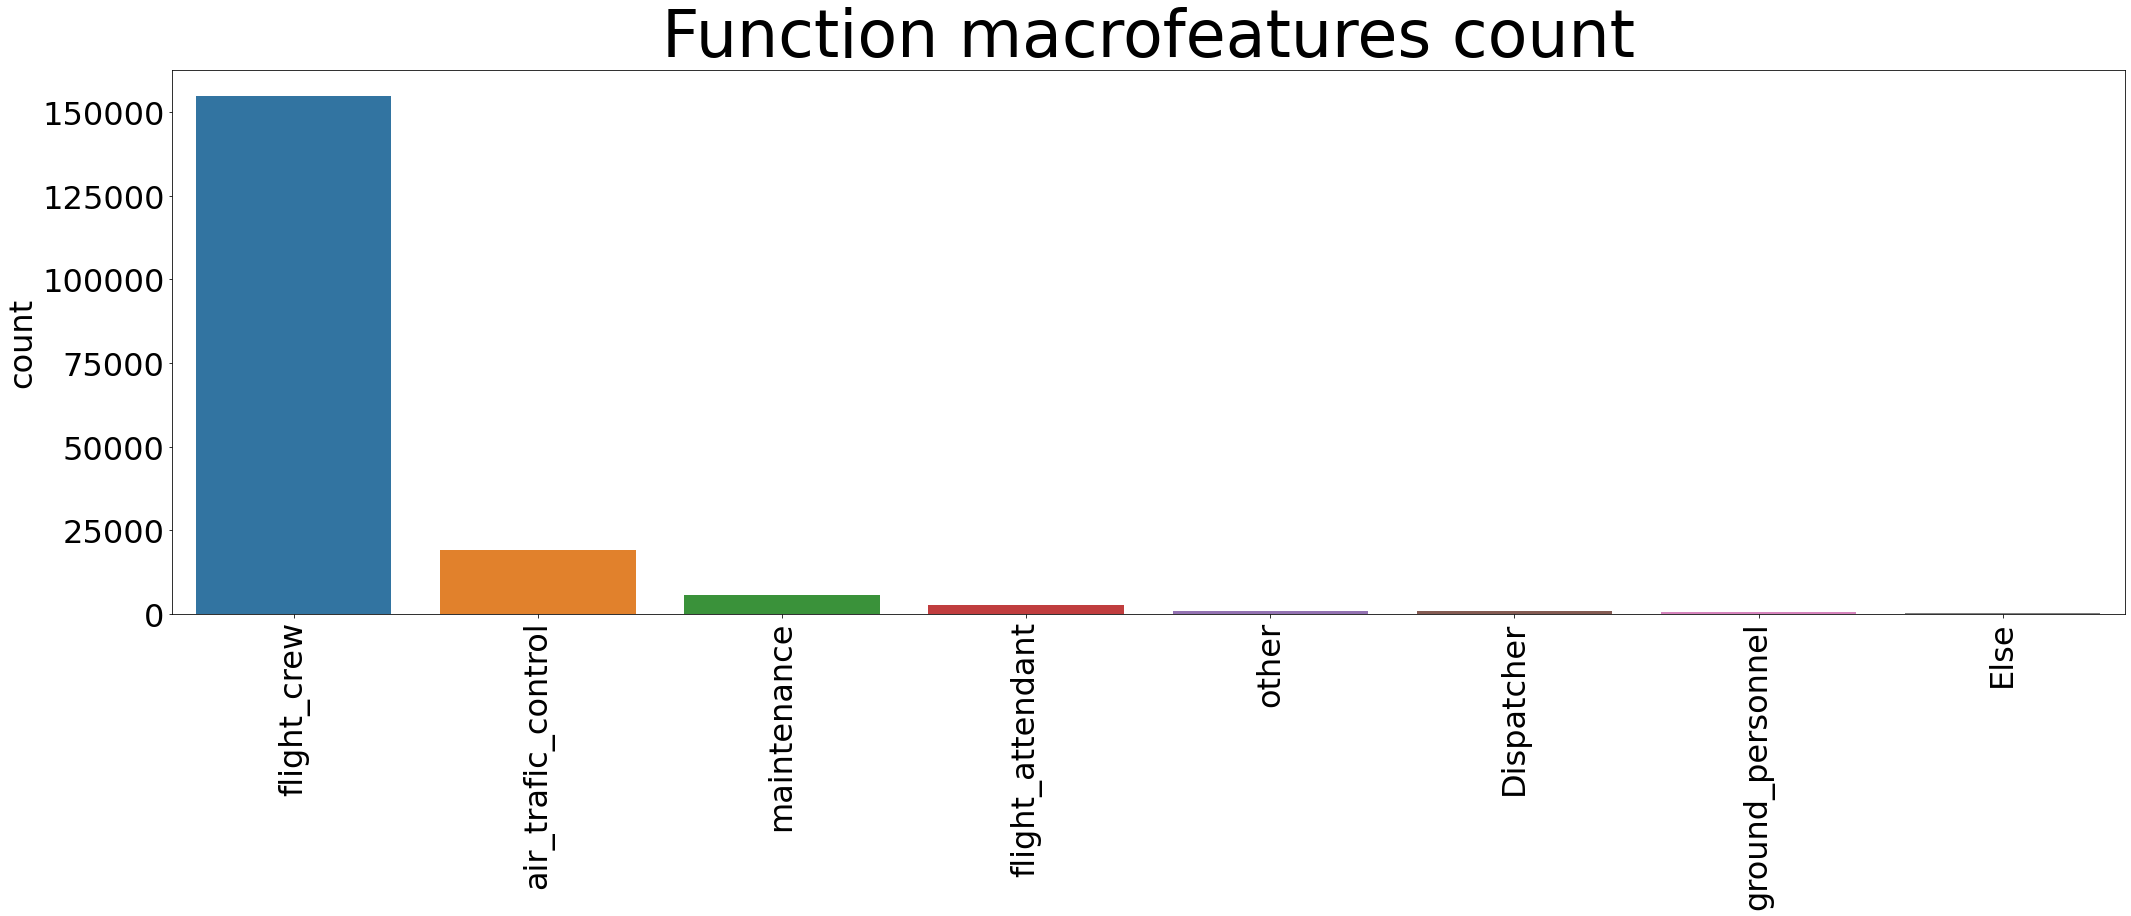

In [64]:
plt.figure(figsize =(35,10))
plt.title('Function macrofeatures count', fontsize=65)
plt.rc('font', size=32)
plt.rc('axes', titlesize=32)
plt.xticks(rotation=90)
sns.countplot(df_function, order = df_function.value_counts().index)

## Experience

In [65]:
df_experience= df['Experience'].str.split(
    '; ', expand=True).stack().reset_index(drop =True)

In [66]:
df_experience = df_experience.dropna()

In [67]:
experience  =  {'Flight Crew' : [],
                 'Air Traffic Control': [],
                 'Maintenance': [],
                 'Flight Attendant': [],
                 'Dispatch':[],
                 'else': []}

In [68]:
for entry in df_experience:
    if 'Flight Crew' in entry:
        experience['Flight Crew'].append(entry)
    elif 'Air Traffic Control' in entry:
        experience['Air Traffic Control'].append(entry)
    elif 'Maintenance' in entry:
        experience['Maintenance'].append(entry)
    elif 'Flight Attendant' in entry:
        experience['Flight Attendant'].append(entry)
    elif 'Dispatch' in entry:
        experience['Dispatch'].append(entry)
    else:
        experience['else'].append(entry) # interesting way to know
                                            # if you have additional
                                            # features that are not
                                            # mentionned in the PDF

In [69]:
for entry in df_experience:
    if 'Flight Crew' in entry:
        df_experience = df_experience.replace(to_replace = entry, value ='Flight Crew')
    elif 'Air Traffic Control' in entry:
        df_experience = df_experience.replace(to_replace = entry, value ='Air Traffic Control')
    elif 'Maintenance' in entry:
        df_experience = df_experience.replace(to_replace = entry, value ='Maintenance')
    elif 'Flight Attendant' in entry:
        df_experience = df_experience.replace(to_replace = entry, value ='Flight Attendant')
    elif 'Dispatch' in entry:
        df_experience = df_experience.replace(to_replace = entry, value ='Dispatch')
    else:
        df_experience = df_experience.replace(to_replace = entry, value ='else')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


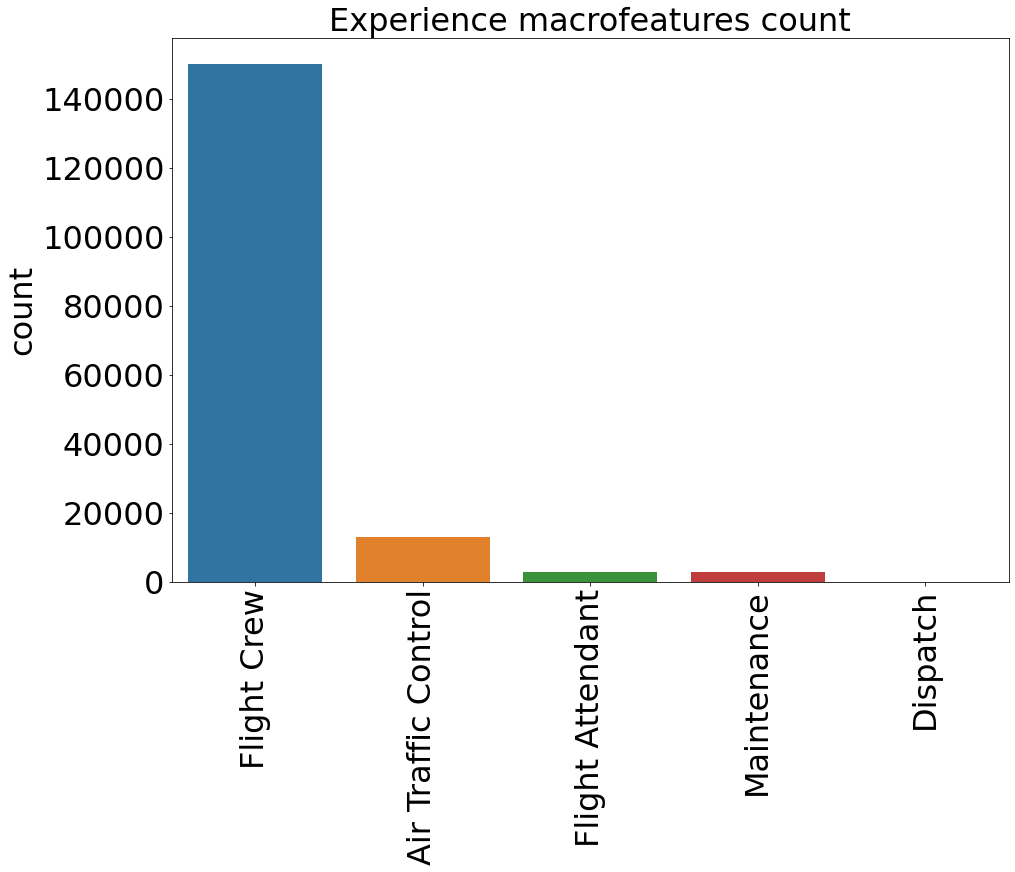

In [70]:
plt.figure(figsize = (15,10))
plt.title('Experience macrofeatures count')
plt.rc('font', size=32)
plt.rc('axes', titlesize=32)
plt.xticks(rotation =90)
sns.countplot(df_experience, order = df_experience.value_counts().index)

## Qualification

In [71]:
df_qualification = df['Qualification'].str.split('; ', expand=True).stack().reset_index(
drop=True)

In [72]:
df_qualification = df_qualification.dropna()

In [73]:
qualification = {'Flight Crew' : [],
                 'Air Traffic Control': [],
                 'Maintenance': [],
                 'Flight Attendant': [],
                 'Dispatch':[],
                 'Other':[],
                 'else': []}

In [74]:
for entry in df_qualification:
    if 'Flight Crew' in entry:
        qualification['Flight Crew'].append(entry)
    elif 'Air Traffic Control' in entry:
        qualification['Air Traffic Control'].append(entry)
    elif 'Maintenance' in entry:
        qualification['Maintenance'].append(entry)
    elif 'Flight Attendant' in entry:
        qualification['Flight Attendant'].append(entry)
    elif 'Dispatch' in entry:
        qualification['Dispatch'].append(entry)
    elif 'Other' in entry:
        qualification['Other'].append(entry)
    else:
        qualification['else'].append(entry) # interesting way to know
                                            # if you have additional
                                            # features that are not
                                            # mentionned in the 

In [75]:
for entry in df_qualification:
    if 'Flight Crew' in entry:
        df_qualification = df_qualification.replace(to_replace = entry, value ='Flight Crew')
    elif 'Air Traffic Control' in entry:
        df_qualification = df_qualification.replace(to_replace = entry, value ='Air Traffic Control')
    elif 'Maintenance' in entry:
        df_qualification = df_qualification.replace(to_replace = entry, value ='Maintenance')
    elif 'Flight Attendant' in entry:
        df_qualification = df_qualification.replace(to_replace = entry, value ='Flight Attendant')
    elif 'Dispatch' in entry:
        df_qualification = df_qualification.replace(to_replace = entry, value ='Dispatch')
    elif 'Other' in entry:
        df_qualification = df_qualification.replace(to_replace = entry, value ='Other')
    else:
        df_qualification = df_qualification.replace(to_replace = entry, value ='Else') # interesting way to know
                                            # if you have additional
                                            # features that are not
                                            # mentionned in the PDF

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


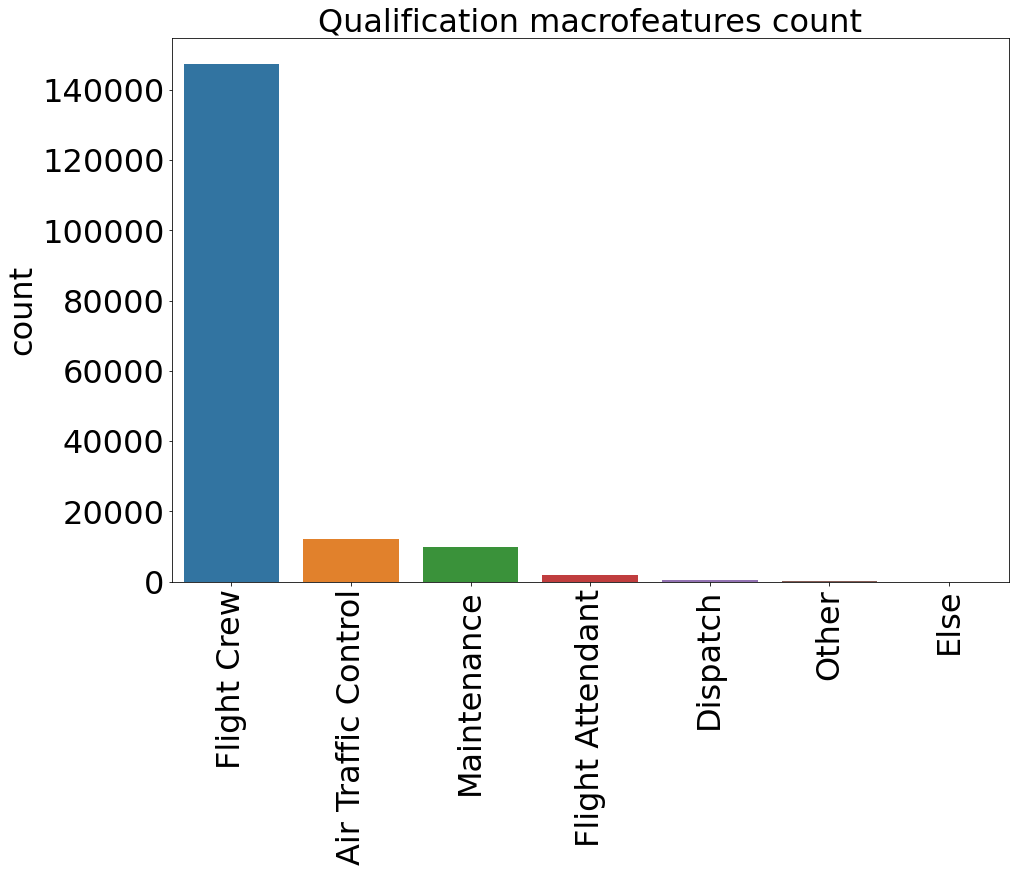

In [76]:
plt.figure(figsize=(15,10))
plt.title('Qualification macrofeatures count')
plt.rc('font', size=32)
plt.rc('axes', titlesize=32)
plt.xticks(rotation =90)
sns.countplot(df_qualification, order = df_qualification.value_counts().index)

In [77]:
# Identification of UAS columns and  :
UAS_columns_list=DF_Dictionary[DF_Dictionary['UAS feature']==True].loc[:,'Column']
print('\n UAS columns list: ', len(UAS_columns_list),' columns \n \n',UAS_columns_list)
all_null=df.loc[:,UAS_columns_list].isna().all(axis = 1).sum()
nb_entries=len(df)
print('\n \n# UAS entries = Not all Nan on UAS columns : ',nb_entries-all_null ,'  (',round((nb_entries-all_null)/nb_entries*100,2),'%)')
print('# Non UAS entries = UAS columns all Nan : ',all_null , '  (',round(all_null/nb_entries*100,2),'%)')


 UAS columns list:  0  columns 
 
 Series([], Name: Column, dtype: object)

 
# UAS entries = Not all Nan on UAS columns :  0   ( 0.0 %)
# Non UAS entries = UAS columns all Nan :  108241   ( 100.0 %)


In [19]:
# Deleting UAS entries in DF
for col_UAS in  UAS_columns_list:
    df = df[df[col_UAS].isnull()]
    
df.shape

(108241, 124)

In [20]:
# Deleting UAS columns in DF
df = df.drop(UAS_columns_list, axis = 1)    
df.shape

(108241, 95)

In [21]:
# Deleting UAS in data dictionary
print(DF_Dictionary.shape)
DF_Dictionary=DF_Dictionary[DF_Dictionary['UAS feature']!=True]
print(DF_Dictionary.shape)

(124, 4)
(95, 4)


# DATA COMPLETION

## Data completion by feature

In [22]:
# Data completion
DF_Completion=pd.DataFrame(df.isnull().sum(axis = 0) ).reset_index() 
DF_Completion=DF_Completion.rename({'index':'Column', 0:'Nan'}, axis = 1)
nb_entries=len(df)
DF_Completion['Completion rate']=1-DF_Completion['Nan']/nb_entries
DF_Completion

DF_Dictionary=DF_Dictionary.merge(right=DF_Completion, on = ['Column'], how='left')
DF_Dictionary.head()

Category                          Column     Type  UAS feature     Nan  \
0     Time                            Date    int64        False       0   
1     Time               Local Time Of Day   object        False    8561   
2    Place                Locale Reference   object        False     814   
3    Place                 State Reference   object        False       0   
4    Place  Relative Position.Angle.Radial  float64        False  102185   

   Completion rate  
0         1.000000  
1         0.920908  
2         0.992480  
3         1.000000  
4         0.055949

In [23]:
DF_Dictionary.shape

(95, 6)

## Data completion by category

In [24]:
## Category_df = DF of distinct feature categories
Category_df=pd.DataFrame(DF_Dictionary['Category'].drop_duplicates(keep='first')).reset_index().drop(['index'], axis = 1)
Category_df


Category
0          Time
1         Place
2   Environment
3    Aircraft 1
4     Component
5    Aircraft 2
6      Person 1
7      Person 2
8        Events
9   Assessments
10     Report 1
11     Report 2

In [ ]:
# Prints a completion report for each features' category
nb_entries=len(df)

for category in Category_df['Category']:
    category_columns_list=DF_Dictionary[DF_Dictionary['Category']==category].loc[:,'Column']
    print('\n',category)
    all_null=df.loc[:,category_columns_list].isna().all(axis = 1).sum()
    print('#records all Nan : ',all_null , '   (',round(all_null/nb_entries*100,2),'%)    /      Not all Nan : ',nb_entries-all_null ,'  (',round((nb_entries-all_null)/nb_entries*100,2),'%)')
    any_null=df.loc[:,category_columns_list].isna().any(axis = 1).sum()
    print('#records any Nan : ',any_null , '   (',round(any_null/nb_entries*100,2),'%)    /      Not any Nan : ',nb_entries-any_null ,'  (',round((nb_entries-any_null)/nb_entries*100,2),'%)')
   


 Time
#records all Nan :  0    ( 0.0 %)    /      Not all Nan :  108241   ( 100.0 %)
#records any Nan :  8561    ( 7.91 %)    /      Not any Nan :  99680   ( 92.09 %)

 Place
#records all Nan :  0    ( 0.0 %)    /      Not all Nan :  108241   ( 100.0 %)
#records any Nan :  108235    ( 99.99 %)    /      Not any Nan :  6   ( 0.01 %)

 Environment
#records all Nan :  19918    ( 18.4 %)    /      Not all Nan :  88323   ( 81.6 %)
#records any Nan :  108237    ( 100.0 %)    /      Not any Nan :  4   ( 0.0 %)

 Aircraft 1
#records all Nan :  1286    ( 1.19 %)    /      Not all Nan :  106955   ( 98.81 %)
#records any Nan :  108241    ( 100.0 %)    /      Not any Nan :  0   ( 0.0 %)

 Component
#records all Nan :  63834    ( 58.97 %)    /      Not all Nan :  44407   ( 41.03 %)
#records any Nan :  107058    ( 98.91 %)    /      Not any Nan :  1183   ( 1.09 %)

 Aircraft 2
#records all Nan :  87357    ( 80.71 %)    /      Not all Nan :  20884   ( 19.29 %)
#records any Nan :  108241    ( 100.0 %

In [ ]:
# Concerning the secondary data (aircraft 2 / person 2 / report 2) :
# 81% of entries have no data for Aircraft 2 features
# 52% of entries have no data for Person 2 features
# 86% of entries have no data for Report 2 features

## YANNIS: Plot unique() and NaN ratio

In [ ]:
# Create an auxiliary dataframe

# Count the total No of entries, unique instances and No of NaN's of each feature
unique_cnts = []
total_entries_feat = []
nan_feat = []

for feat in df.columns:
  unique_cnts.append(len(df[str(feat)].unique()))
  total_entries_feat.append(len(df[str(feat)]))
  nan_feat.append(df[str(feat)].isna().sum())    # count No of NaN's

# Write the counts into a new df for easier handling the seaborn plot
my_df = pd.DataFrame({'feature': df.columns,
                      'unique counts': unique_cnts,
                      'total_entries_feat': total_entries_feat,
                      'nan_features':   nan_feat
                      })

# Add an entry with the max count possible, i.e. len(df)
new_entry = pd.DataFrame({'feature' : ['Total No of entries'],
                          'unique counts': [len(df)]
                          })
my_df = pd.concat([my_df, new_entry], ignore_index = True, axis = 0)

# Sort dataframe in descending order of unique counts
my_df = my_df.sort_values(by = 'unique counts', ascending = False)

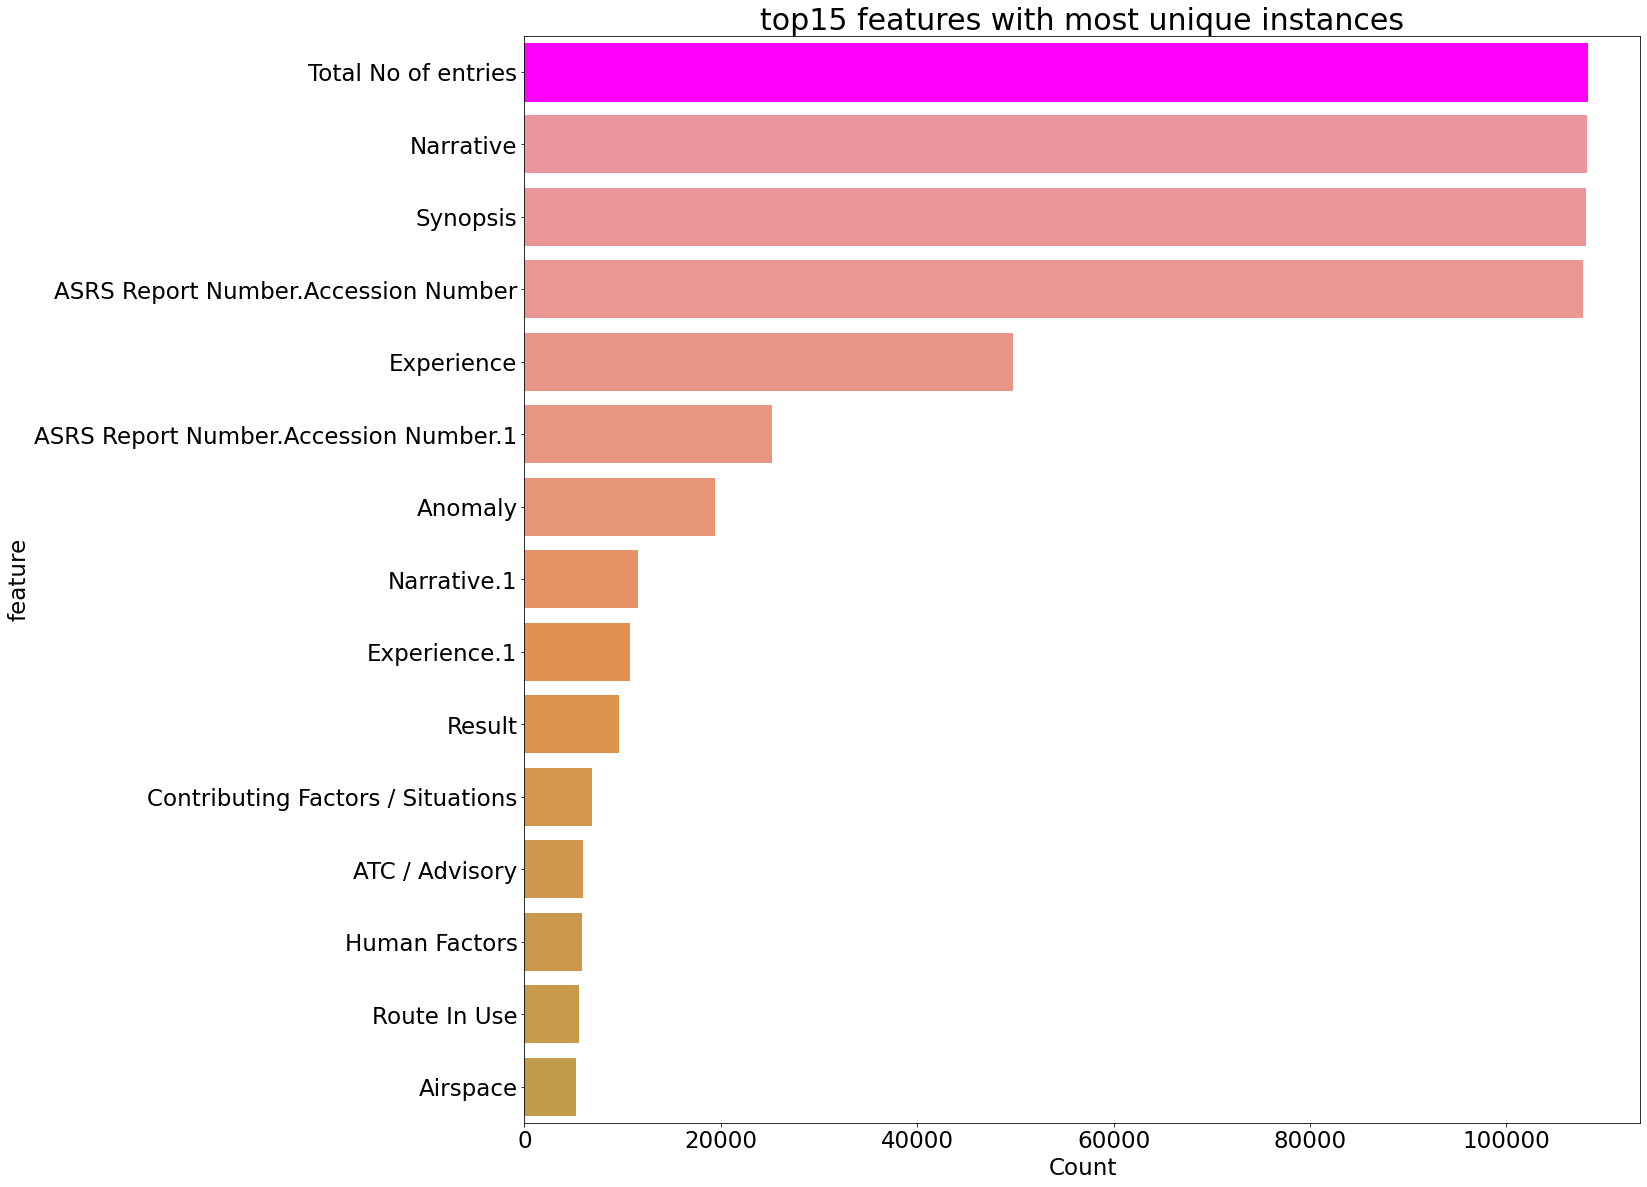

In [ ]:
# Barplot of unique features
fig = plt.figure(figsize = (20,20))
ax = sns.barplot(data = my_df, x = 'unique counts', y = 'feature')

# Color the top bar
for bar in ax.patches:
    if bar.get_y() < 0.5: # get_y() returns the bottom coordinate of the rectangle 
                          # given a vertical bar layout --> here '< 0.5' means the topmost bar
        bar.set_color('magenta')

# Plot the 15 most frequent occurences
topX = 15
plt.ylim(topX - 0.5)
plt.xlabel('Count')
plt.title(f"top{topX} features with most unique instances");

In [ ]:
# Add additional columns to the DataFrame: completetion percentage and scaled number of unique counts
my_df['compl_percent'] = np.round(100 * (1 - (my_df['nan_features'] / my_df['total_entries_feat'])), 1)
my_df['unique_cnts_scaled'] = my_df['unique counts'] / 1000 # scale in thousands, to plot along the percentages

# For the next plot below: sort dataframe in descending order of completion percentage
my_df = my_df.sort_values(by = 'compl_percent', ascending = False)

my_df.head()

feature  unique counts  total_entries_feat  \
90                            Narrative         108223            108241.0   
0                                  Date            243            108241.0   
94                             Synopsis         108090            108241.0   
3                       State Reference             68            108241.0   
71  ASRS Report Number.Accession Number         107815            108241.0   

    nan_features  compl_percent  unique_cnts_scaled  
90           0.0          100.0             108.223  
0            0.0          100.0               0.243  
94          11.0          100.0             108.090  
3            0.0          100.0               0.068  
71         312.0           99.7             107.815

In [ ]:
# BOKEH PLOT
# Did not manage to rotate the legend box and legend text 
# --> copy/pasteed the legend with .ppt for including it into the report
source = ColumnDataSource(my_df)

f = figure(width = 1800, height = 600, x_range = my_df['feature'])
f.xaxis.major_label_orientation = np.pi/2
f.yaxis.major_label_orientation = np.pi/2


abcisses1 = dodge(field_name = 'feature', value = -0.25, range = f.x_range)
abcisses2 = dodge(field_name = 'feature', value = 0, range = f.x_range)
#abcisses3 = dodge(field_name = 'x', value = 0.25, range = f.x_range)

v1 = f.vbar(source = source, x = abcisses1, top = 'unique_cnts_scaled', width = 0.2, color = 'blue', legend_label = "unique counts [thousands]")
v2 = f.vbar(source = source, x = abcisses2, top = 'compl_percent', width = 0.2, color = 'green', legend_label = "completion percentage (how many NaN's)")
#v3 = f.vbar(source = source, x = abcisses3, top = 'valeur 3', width = 0.2, color = 'blue', legend_label = "Valeur 3")

# Create HoverTool
h = HoverTool(renderers = [v1, v2],  # liste de GlyphRenderer avec lesquels on veut intéragir
    
              tooltips = [( "feature", "@feature"), 
                          ("unique counts [thousands]", "@unique_cnts_scaled"),
                          ("completeness percentage", "@compl_percent")
                          ]) # liste de couples d'informations à afficher à coté du point survolé. Les informations que nous affichons sont les coordonnées du point survolé.  
f.add_tools(h)
f.legend.location ='center'
# f.legend.visible=False # hide the legend
show(f)

## Flag of completion for categories "Aircraft 2" "Person 2" and "Report 2"

In [ ]:
print(df.shape)
category_list_to_study=['Aircraft 2','Person 2','Report 2']
category_list_to_study_col=[]
for category in category_list_to_study:
    category_columns_list=DF_Dictionary[DF_Dictionary['Category']==category].loc[:,'Column']
    all_null=df.loc[:,category_columns_list].isna().all(axis = 1) 
    col='Theme_'+category+'_completion'
    category_list_to_study_col.append(col)
    df[col]=all_null.astype('str').apply(lambda x: 'Empty' if x=='True' else 'At least 1 data')
print(df.shape)

(108241, 95)
(108241, 98)


In [ ]:
pd.crosstab(df['Theme_Person 2_completion'],df['Theme_Report 2_completion'], rownames=['Person 2'], colnames=['Report 2'])
# Report 2 is probably written by Person 2 (no Report 2 for entries without Person 2 data)

Report 2         At least 1 data  Empty
Person 2                               
At least 1 data            14831  36587
Empty                          1  56822

In [ ]:
pd.crosstab(df['Theme_Aircraft 2_completion'],df['Theme_Person 2_completion'], rownames=['Aircraft 2'], colnames=['Person 2'])
# Aircraft 2 and Person 2 are independant : there are entries for Person 2 without Aircraft 2 data and vice versa

Person 2         At least 1 data  Empty
Aircraft 2                             
At least 1 data            11239   9645
Empty                      40179  47178

In [ ]:
pd.crosstab(df['Theme_Aircraft 2_completion'],df['Theme_Report 2_completion'], rownames=['Aircraft 2'], colnames=['Report 2'])
# Aircraft 2 and Report 2 are independant : there are entries for Report 2 without Aircraft 2 data and vice versa

Report 2         At least 1 data  Empty
Aircraft 2                             
At least 1 data             2142  18742
Empty                      12690  74667

In [ ]:
df=df.drop(category_list_to_study_col,axis=1)
print(df.shape)

(108241, 95)


# FEATURE ENGINEERING

## Create 'Year' feature

In [ ]:
df.Date.value_counts()
# The 'Date' feature contains 'AAAAMM' dates (for anonymisation issues)
# See in the tail : that for 2005 and 2006, a few entries had the date with only 'AAAA'

200203    848
200201    808
200310    785
200306    761
200202    744
200311    732
200305    720
200304    716
200807    710
200303    707
200204    704
200307    684
200607    664
200208    655
200610    652
200308    647
200806    645
200309    641
200205    637
201911    622
200405    622
200606    620
200805    616
200608    615
201507    603
200907    601
201909    595
201910    590
200410    589
200611    586
200804    586
200301    576
200302    575
200612    571
201111    569
201612    567
201907    565
200312    560
200803    559
200210    558
201908    557
201511    556
201812    554
201110    549
201508    545
202007    541
200403    540
200409    540
200605    537
200604    536
200404    532
200811    528
200603    528
201604    527
200408    525
200808    515
200401    512
200407    510
201003    506
201506    503
201901    503
200411    497
201810    497
201007    496
200906    496
201701    496
201106    495
200406    491
200609    490
201512    490
200810    489
201906

In [ ]:
df['Year']=df.Date.astype(str).apply(lambda x :  x if  len(x)==4 else int(x[:-2]) ).astype(int) 

In [ ]:
# Check : OK
functions_to_apply = {
    'Date' : ['min', 'max']}
df.groupby('Year').agg(functions_to_apply)


Date        
         min     max
Year                
2002  200201  200212
2003  200301  200312
2004  200401  200412
2005    2005  200512
2006    2006  200612
2007  200701  200712
2008  200801  200812
2009  200901  200912
2010  201001  201012
2011  201101  201112
2012  201201  201212
2013  201301  201312
2014  201401  201412
2015  201501  201512
2016  201601  201612
2017  201701  201712
2018  201801  201812
2019  201901  201912
2020  202001  202012
2021  202101  202112
2022  202201  202201

## Merge Stat_Reference_df & Create 'State' features

In [ ]:
df=df.merge(right=Stat_Reference_df, on = ['State Reference'], how='inner')

In [ ]:
df.shape

(108241, 98)

- Nouvelle colonne 'State Location Known' : False si State Referebce =  US or FO , True sinon

In [ ]:
df['State Location Known']=df['State Reference'].apply(lambda s :  False if  s in ('US','FO') else True )  

# DATA DISCOVERY

## Quantitative data

### Statistics

In [ ]:
# "Quantitative" data description (including ACN, ASRS Number and ASRS Number.1 = IDs)
df.describe().T
# We can see empty columns in the '.1' colummns = second report data


count          mean  \
Date                                         108241.0  2.010897e+05   
Relative Position.Angle.Radial                 6056.0  1.837367e+02   
Relative Position.Distance.Nautical Miles     26506.0  1.473551e+01   
Altitude.MSL.Single Value                     49825.0  1.274838e+04   
Crew Size                                     98765.0  1.831448e+00   
Number Of Seats.Number                          554.0  1.579531e+02   
Passengers On Board.Number                      472.0  1.210530e+02   
Crew Size Flight Attendant.Number Of Crew       149.0  5.006711e+00   
Aircraft Zone.1                                   0.0           NaN   
Crew Size.1                                   14464.0  1.632812e+00   
Maintenance Status.Records Complete.1             0.0           NaN   
Number Of Seats.Number.1                          6.0  1.610000e+02   
Passengers On Board.Number.1                      4.0  1.452500e+02   
Crew Size Flight Attendant.Number Of Crew.1       0.0           NaN   
ASRS Report Number.Accession Number          107929.0  1.117876e+06   
ASRS Report Number.Accession Number.1         25251.0  3.247471e+07   
Year                                         108241.0  2.010906e+03   

                                                      std     min        25%  \
Date                                         1.345342e+03  2005.0  200605.00   
Relative Position.Angle.Radial               1.060863e+02     0.0      90.00   
Relative Position.Distance.Nautical Miles    6.010431e+01     0.0       0.00   
Altitude.MSL.Single Value                    1.280071e+04     0.0    3000.00   
Crew Size                                    4.871181e-01     0.0       2.00   
Number Of Seats.Number                       5.729188e+01     0.0     129.00   
Passengers On Board.Number                   6.912977e+01     0.0      71.50   
Crew Size Flight Attendant.Number Of Crew    3.392154e+00     1.0       3.00   
Aircraft Zone.1                                       NaN     NaN        NaN   
Crew Size.1                                  5.372694e-01     0.0       1.00   
Maintenance Status.Records Complete.1                 NaN     NaN        NaN   
Number Of Seats.Number.1                     9.001555e+01     3.0     140.75   
Passengers On Board.Number.1                 4.574841e+01   100.0     117.25   
Crew Size Flight Attendant.Number Of Crew.1           NaN     NaN        NaN   
ASRS Report Number.Accession Number          2.168573e+07     7.0  698880.00   
ASRS Report Number.Accession Number.1        4.942923e+09     1.0  716003.00   
Year                                         5.874757e+00  2002.0    2006.00   

                                                  50%         75%  \
Date                                         201102.0   201607.00   
Relative Position.Angle.Radial                  180.0      270.00   
Relative Position.Distance.Nautical Miles         3.0       13.00   
Altitude.MSL.Single Value                      7000.0    21000.00   
Crew Size                                         2.0        2.00   
Number Of Seats.Number                          150.0      188.00   
Passengers On Board.Number                      129.0      172.50   
Crew Size Flight Attendant.Number Of Crew         4.0        6.00   
Aircraft Zone.1                                   NaN         NaN   
Crew Size.1                                       2.0        2.00   
Maintenance Status.Records Complete.1             NaN         NaN   
Number Of Seats.Number.1                        176.5      204.75   
Passengers On Board.Number.1                    137.5      165.50   
Crew Size Flight Attendant.Number Of Crew.1       NaN         NaN   
ASRS Report Number.Accession Number          937732.0  1375193.00   
ASRS Report Number.Accession Number.1        970568.0  1374179.50   
Year                                           2011.0     2016.00   

                                                      max  
Date                     

### YANNIS: Correlation matrix
ADD HERE CORRELATION MATRIX ...

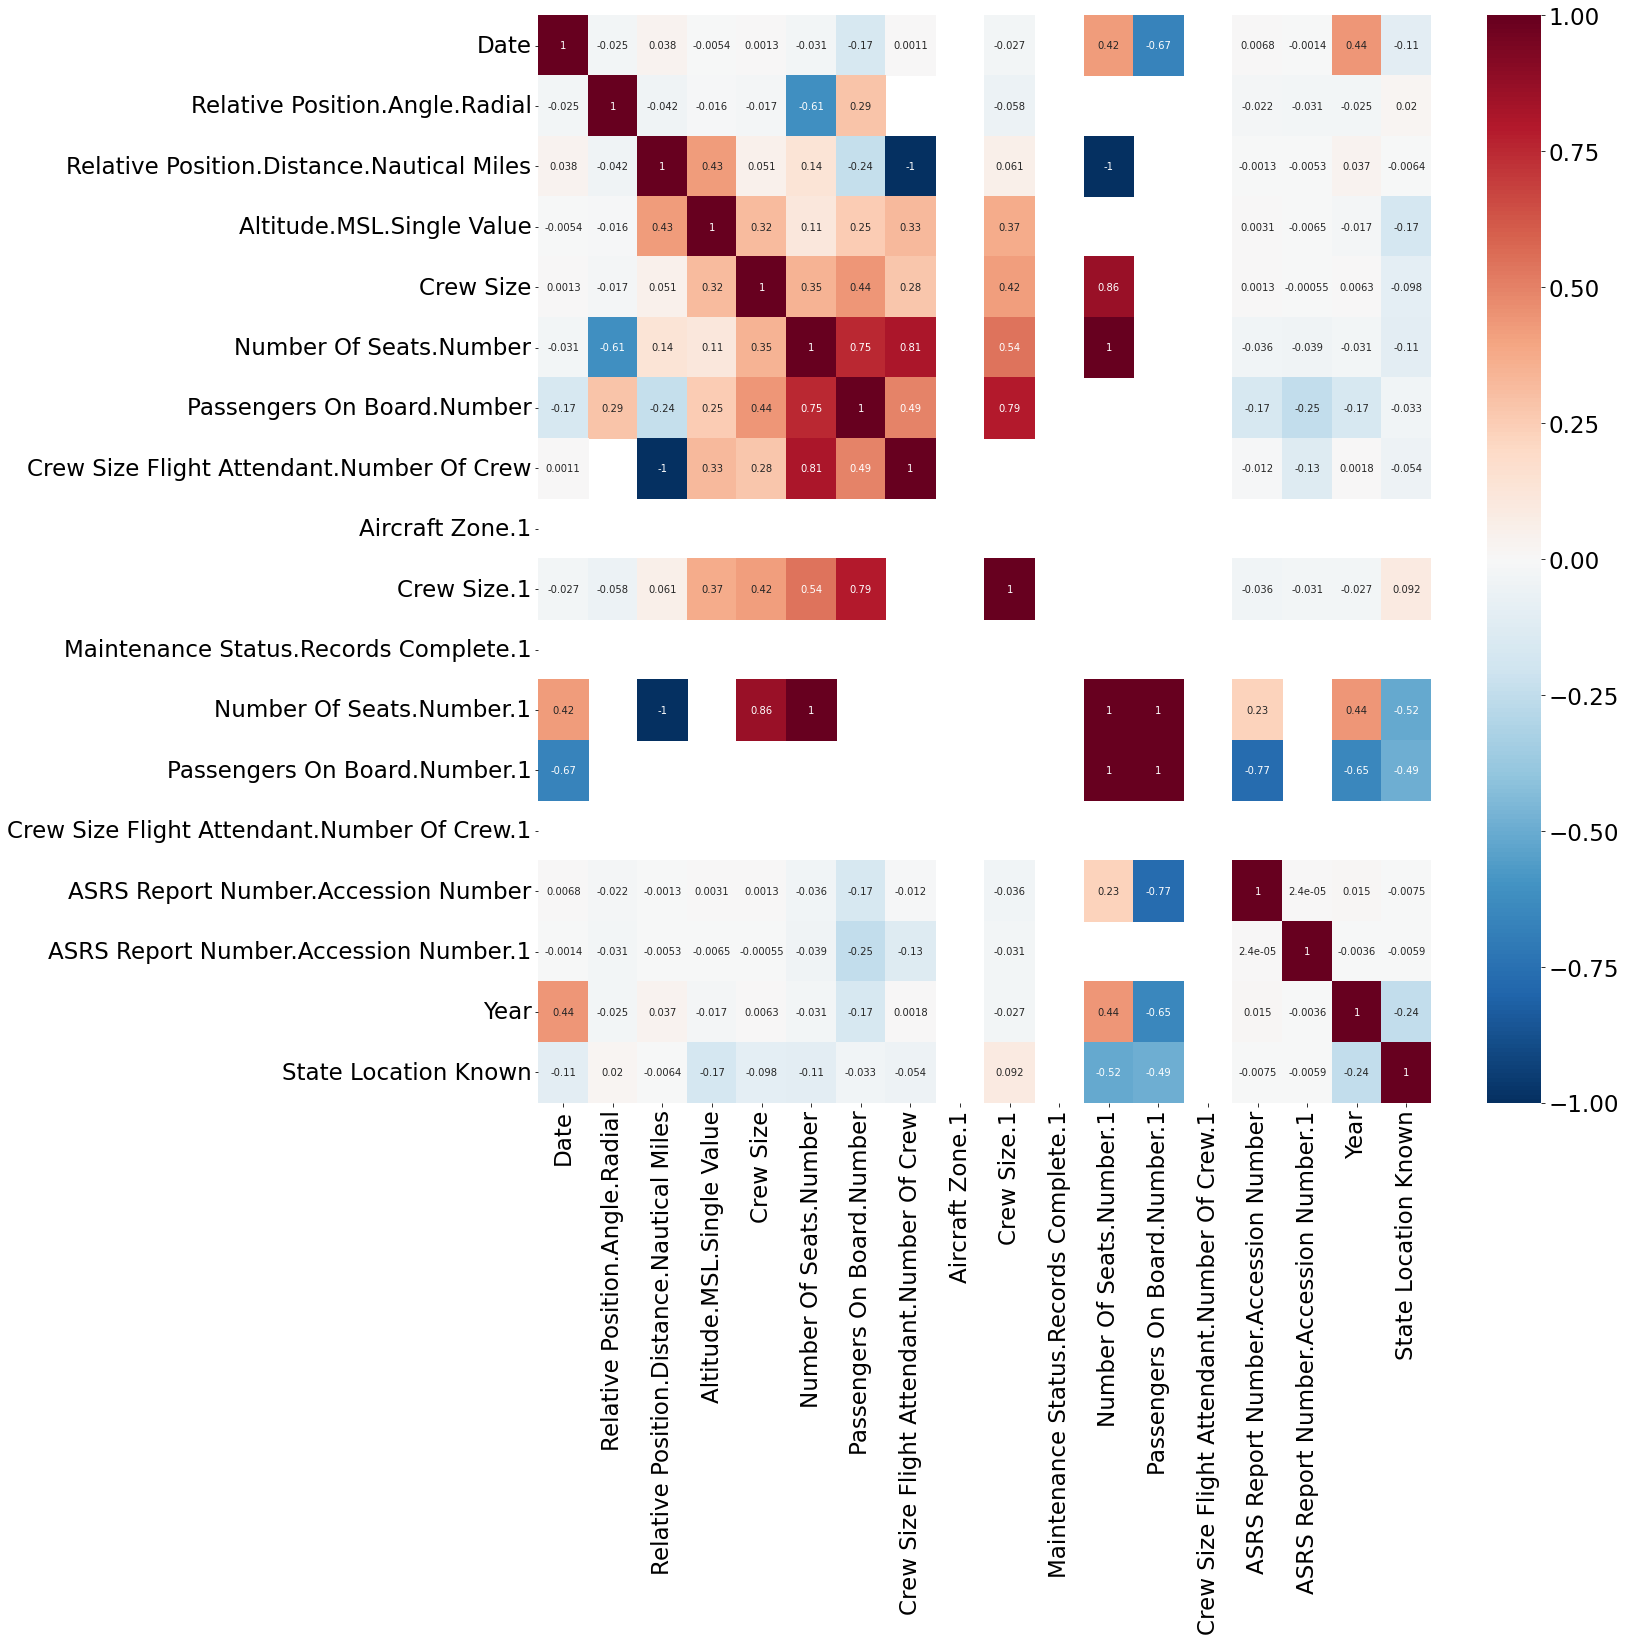

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, cmap='RdBu_r', center=0);

## Qualitative data analysis

In [ ]:
# CLassification of variables according to their role
df_cat_data=df.select_dtypes(include='O').drop(['Narrative','Narrative.1','Callback','Callback.1','Synopsis'], axis = 1)  # ou cat_data=df.select_dtypes(include='object')
df_cat_data.shape

(108241, 76)

### Top 20 modalities

In [ ]:
nb_null=0
nb_entries=len(df_cat_data)
N=20 # Nbr of rows in the top
for col in df_cat_data.columns :
    print("\n")
    print("VARIABLE : ",col, )
    nb_null=df_cat_data[col].isnull().sum(axis = 0)
    print('NaN VALUES : ',nb_null , '   (',round(nb_null/nb_entries*100,2),'%)    /     Non NaN VALUES : ',nb_entries-nb_null ,'  (',round((nb_entries-nb_null)/nb_entries*100,2),'%)')
    S=df_cat_data[col].value_counts(dropna=True, normalize=False)
    print("    Nbr of modalities (excluding Nan) : ",len(S) )
    S2=df_cat_data[col].value_counts(dropna=False, normalize=False)
    S_topN=S2.head(N)
    print('TOP ',len(S_topN) ,'MODALITIES',S_topN.sum(), '   (',round(S_topN.sum()/nb_entries*100,2),'%)' )
    print(S_topN)    
    
# Certaines variables sont à parser (à lister) avant le value_counts comme 'Weather Elements / Visibility' (cf cellule suivante)



VARIABLE :  Local Time Of Day
NaN VALUES :  8561    ( 7.91 %)    /     Non NaN VALUES :  99680   ( 92.09 %)
    Nbr of modalities (excluding Nan) :  5
TOP  6 MODALITIES 108241    ( 100.0 %)
1201-1800    38398
0601-1200    28881
1801-2400    22181
0001-0600    10197
NaN           8561
ZZZ             23
Name: Local Time Of Day, dtype: int64


VARIABLE :  Locale Reference
NaN VALUES :  814    ( 0.75 %)    /     Non NaN VALUES :  107427   ( 99.25 %)
    Nbr of modalities (excluding Nan) :  4901
TOP  20 MODALITIES 61258    ( 56.59 %)
ZZZ.Airport     38728
ZZZ.ARTCC        5264
ZZZZ.Airport     2055
ZZZ.TRACON       1892
ORD.Airport      1442
LAX.Airport      1192
TEB.Airport      1056
DFW.Airport      1023
DEN.Airport       938
SFO.Airport       929
LAS.Airport       863
ATL.Airport       840
NaN               814
ZZZ.Tower         723
ZZZZ.ARTCC        644
LGA.Airport       617
EWR.Airport       615
PHL.Airport       558
MIA.Airport       544
JFK.Airport       521
Name: Locale Reference

### Analysis of Nbr of modalities per year for all categorical features

In [ ]:
years=list(range(min(df['Year']),max(df['Year']+1)))
years

[2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022]

In [ ]:
# Definition of DF counting the # of features'modalities per year
# Initialization of a DF with the studied years

df_len_multiple = pd.DataFrame(years, columns = ['Year'])
df_len_multiple['Year']=df_len_multiple['Year'].astype(int)

In [ ]:
#
cat_features_list=df.select_dtypes(include='O').drop(['Narrative','Narrative.1','Callback','Callback.1','Synopsis'], axis = 1).columns # ou cat_data=df.select_dtypes(include='object')

for cat_feature in cat_features_list:
    list_len=[]
    for y in years:
        df_year=df[df['Year']==y]
        Feature_split=df_year[cat_feature].astype(str).str.split('; ', expand=True).stack().reset_index(drop=True)
        Feature_split=pd.DataFrame(Feature_split).rename(columns={0:'Col'})
        Feature_split=Feature_split.drop_duplicates()
        Feature_split=Feature_split.sort_values(by='Col', ascending = True)
        list_len.append(len(Feature_split))

    df_len_multiple=pd.concat([df_len_multiple, pd.DataFrame(list_len, columns = [cat_feature+' Modality count'])],axis = 1)

df_len_multiple

Year  Local Time Of Day Modality count  Locale Reference Modality count  \
0   2002                                 5                             1526   
1   2003                                 5                             1581   
2   2004                                 5                             1410   
3   2005                                 5                              763   
4   2006                                 5                             1345   
5   2007                                 5                              940   
6   2008                                 5                              863   
7   2009                                 6                              710   
8   2010                                 5                              639   
9   2011                                 6                              669   
10  2012                                 6                              605   
11  2013                                 6                              543   
12  2014                                 5                              698   
13  2015                                 5                              875   
14  2016                                 5                              725   
15  2017                                 6                              739   
16  2018                                 6                              764   
17  2019                                 6                              673   
18  2020                                 6                              537   
19  2021                                 5                              535   
20  2022                                 5                               79   

    State Reference Modality count  Altitude.AGL.Single Value Modality count  \
0                               62                                        60   
1                               64                                        65   
2                               64                                        55   
3                               58                                        47   
4                               61                                        78   
5                               61                                        97   
6                               62                                        67   
7                               61                                        64   
8                               59                                        50   
9                               60                                        43   
10                              59                                        49   
11                              59                                        50   
12                              61                                        45   
13                              62                                        55   
14                              61                                        58   
15                              60                                        51   
16                              61                                        63   
17                              58                                        66   
18                              60                                        53   
19                              57                                        64   
20                              23                                        17   

    Flight Conditions Modality count  \
0                                  5   
1                                  5   
2                                  5   
3                                  5   
4                                  5   
5                                  5   
6                                  5   
7                                  5   
8                                  5   
9                                  5   
10                                 5   
11                      

#### Focus on 'Anomaly feature

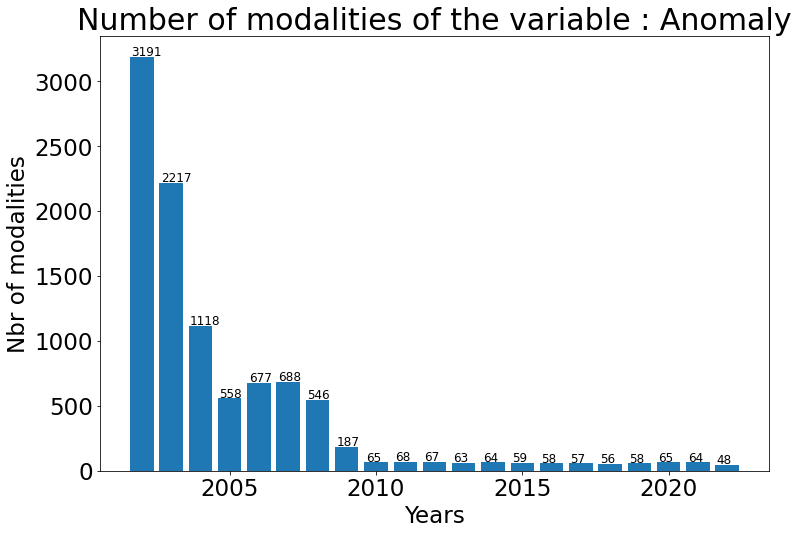

In [ ]:
plt.figure( figsize= (12, 8) ) 
plt.bar(df_len_multiple['Year'],df_len_multiple['Anomaly Modality count'])
plt.title('Number of modalities of the variable : Anomaly')
plt.xlabel('Years')
plt.ylabel('Nbr of modalities')
for y, v in zip(df_len_multiple['Year'],df_len_multiple['Anomaly Modality count']):
  plt.text(y-0.35 , v+35           # si bar au lieu de barh : inverser v et i
            ,str(v)
            , color='black'
            , fontsize = 12
          ,va='center');


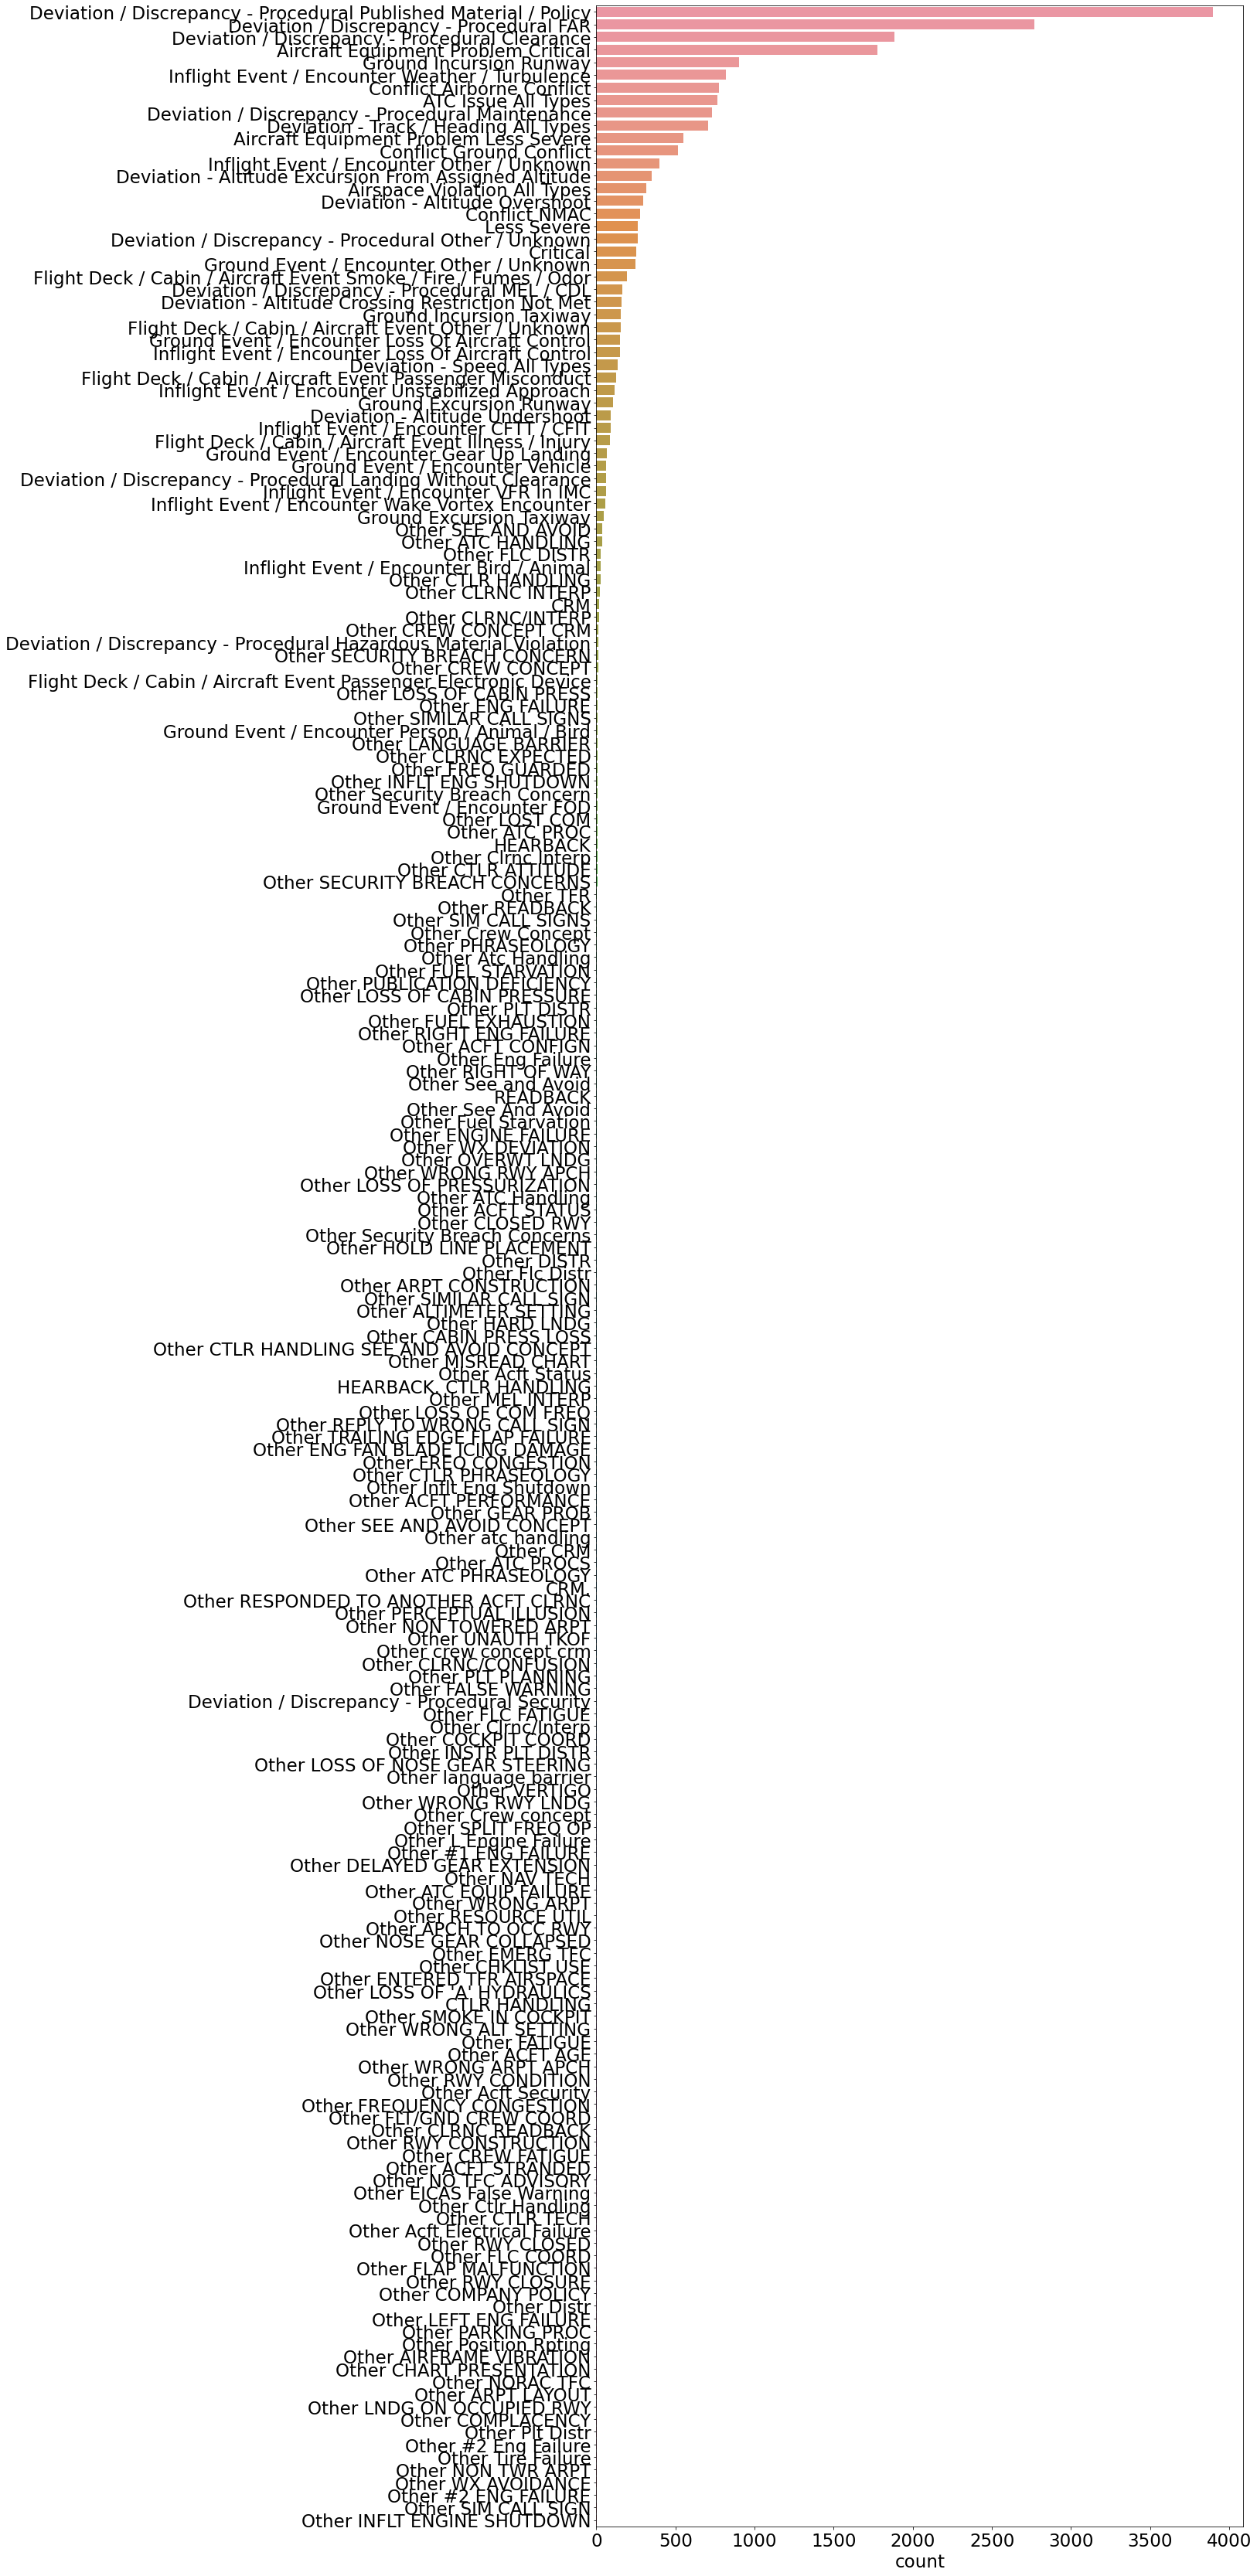

In [ ]:
# 'Anomaly' column parsing & Top modalities in 2002
Anomaly=df[df['Year']==2002]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
fig, ax = plt.subplots(figsize=(15,60))
sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:200].index);

# High number of very low populated "textual" modalities (see bottom)

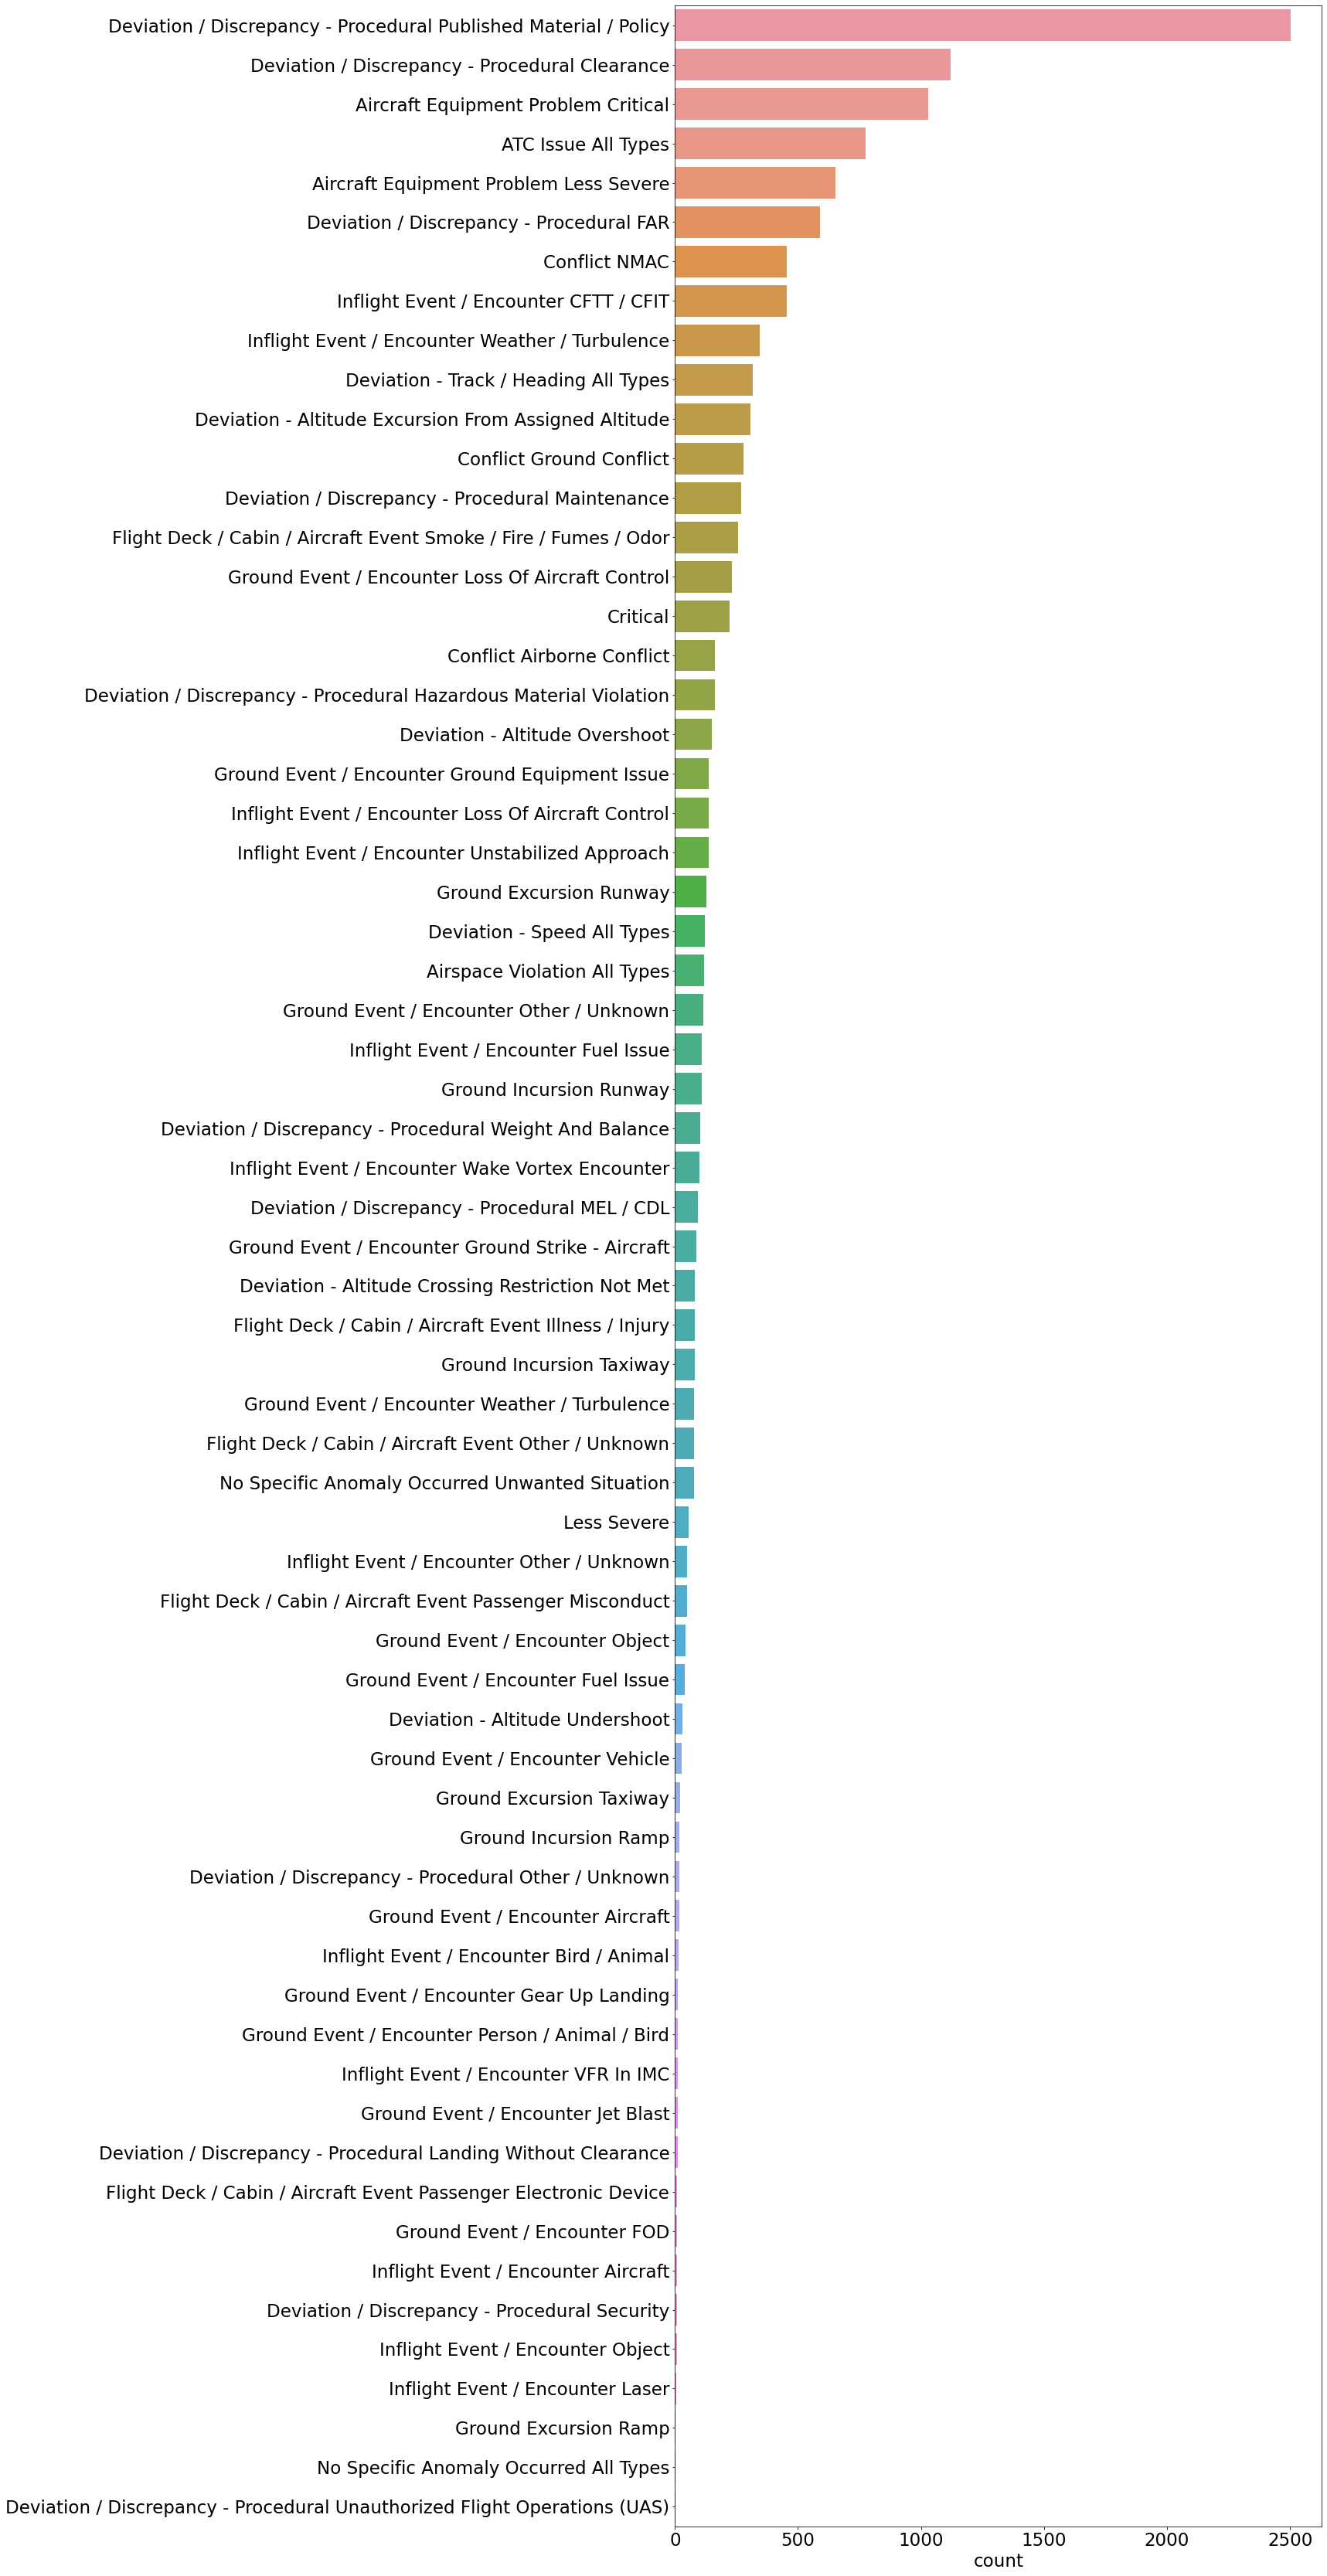

In [ ]:
# 'Anomaly' column parsing & Top modalities in 2021
Anomaly=df[df['Year']==2021]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
fig, ax = plt.subplots(figsize=(15,60))
sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:200].index);

# Fewer modalities, populated with descrepancies, with a hierarchical structure (see ASRS coding forms)


## Textual data analysis

In [ ]:
# CLassification of variables according to their role
df_text_data=df.loc[:,['Narrative','Narrative.1','Callback','Callback.1','Synopsis']]  
df_text_data.shape
#(108407, 96)

(108241, 5)

In [ ]:
nb_null=0
nb_entries=len(df_text_data)
N=20 # Nbr of rows in the top
for col in df_text_data.columns :
    print("\n")
    print("VARIABLE : ",col, )
    nb_null=df_text_data[col].isnull().sum(axis = 0)
    print('VALEURS NaN : ',nb_null , '   (',round(nb_null/nb_entries*100,2),'%)    /      VALEURS NON VIDES : ',nb_entries-nb_null ,'  (',round((nb_entries-nb_null)/nb_entries*100,2),'%)')
    S=df_text_data[col].value_counts(dropna=True, normalize=False)
    print("    Nombre de modalités (hors Nan) : ",len(S) )
    S2=df_text_data[col].value_counts(dropna=False, normalize=False)
    S_topN=S2.head(N)
    print('TOP ',len(S_topN) ,'VALEURS',S_topN.sum(), '   (',round(S_topN.sum()/nb_entries*100,2),'%)' )
    print(S_topN)    
    
 



VARIABLE :  Narrative
VALEURS NaN :  0    ( 0.0 %)    /      VALEURS NON VIDES :  108241   ( 100.0 %)
    Nombre de modalités (hors Nan) :  108223
TOP  20 VALEURS 38    ( 0.04 %)
SAFETY IS BEING COMPROMISED BECAUSE OF REDUCTION OF STAFFING ON THE XA15 TO XI15 SHIFT MONDAY THRU FRIDAY. THE SOUTH AREA CONSISTS OF SEVEN SECTORS; THREE HIGH ALT SECTORS AND FOUR LOW ALT SECTORS. THEY CONTROL OVER-FLT TFC AS WELL AS INBOUND TFC TO SEVERAL ARPTS. MANAGEMENT HAS DECIDED TO REDUCE THE STAFFING ON THIS SHIFT FROM FOUR CTLRS TO THREE CTLRS. THE FOLLOWING REASONS ARE WHY IT IS UNSAFE TO REDUCE THE SHIFT STAFFING IN THE ZME/SOUTH AREA: 1) THE AREA WORKS AND PROVIDES IN-TRAIL SPACING FOR MEM ARRS FROM THE SOUTHWEST OVER THE UJM ARR GATE. THE ARRS LAST UNTIL XD30 LCL AND WHEN MEM IS IN A SOUTH CONFIGURATION IT IS NOT UNCOMMON FOR THE AREA TO HAVE TO HOLD SEVERAL OF THESE ARRS. NORMALLY; THIS HOLDING OCCURS AFTER XC00 LCL. 2) THE AREA ALSO ASSUMES THE RESPONSIBILITIES OF TWO APCH CTLS; JAN AND MEI. 

#DATAVIZ

## Time analysis

In [ ]:
import seaborn as sns
sns.set_theme() 
sns.set_style('whitegrid')

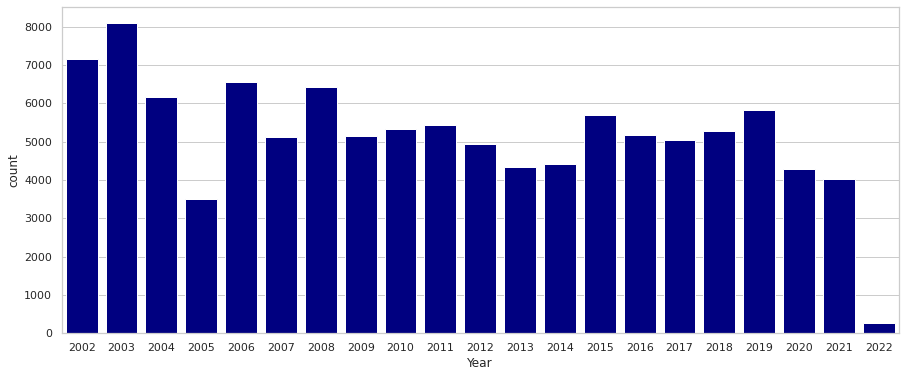

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x=df['Year'],color="navy",saturation=1,ax=ax);

# A volume decrease in the start of the period and then a plateau , up to 2020/2021 due to COVID context 
# 2022 : data extraction ends at 2022/01
# Drop in 2005 : explanation ?

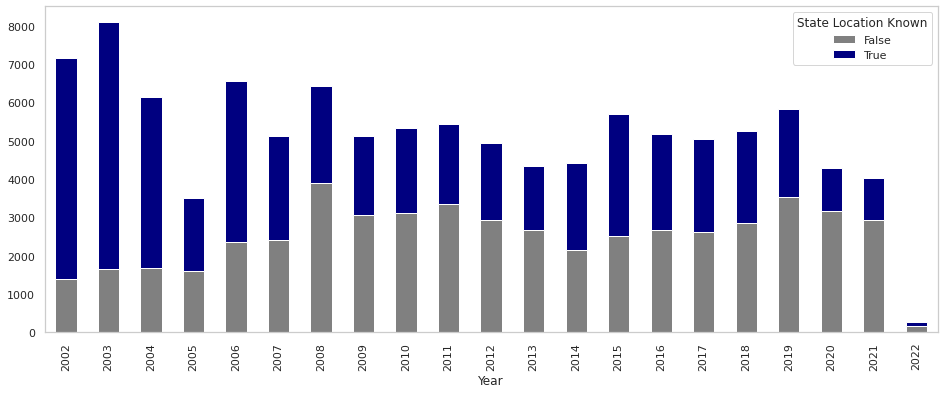

In [ ]:
df_plot = df.groupby(['Year', 'State Location Known']).size().reset_index().pivot(columns='State Location Known', index='Year', values=0)
fig, ax = plt.subplots(figsize=(16,6))
df_plot.plot(kind='bar', color = ['grey', 'navy'], stacked=True,ax=ax)
plt.grid(False);


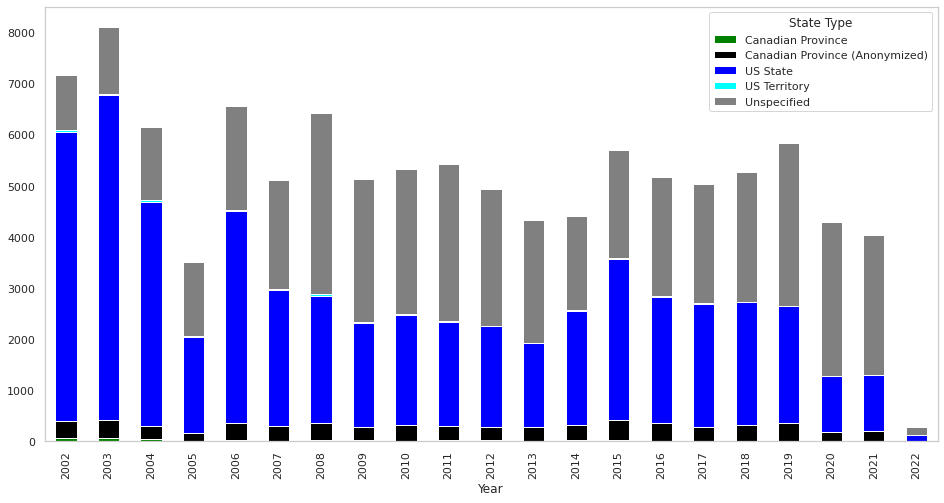

In [ ]:
df_plot = df.groupby(['Year', 'State Type']).size().reset_index().pivot(columns='State Type', index='Year', values=0)
fig, ax = plt.subplots(figsize=(16,8))
df_plot.plot(kind='bar', color = ['green','black','blue','cyan','grey' ], stacked=True,ax=ax)
plt.grid(False);

## YANNIS: Candidate target variables

### Primary Problem

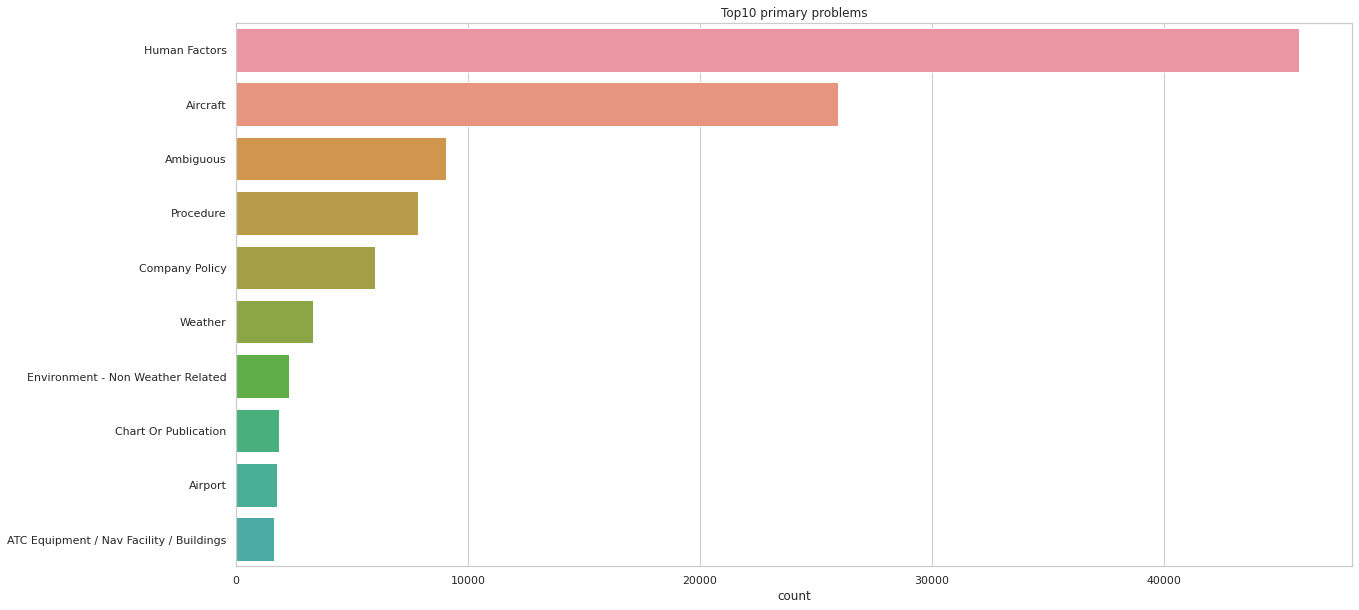

In [ ]:
# Instantiate new figure
fig = plt.figure(figsize= (20,10))
ax = fig.add_subplot(111) # need the ax handle to set the ylabels to None

# Plot in decreasing order
sns.countplot(y = df['Primary Problem'], 
              order = df['Primary Problem'].value_counts().index, 
              orient = 'h')

# Plot settings
plt.title('Top10 primary problems')
ax.set(ylabel = None)
# Plot the 10 most frequent occurences
topX = 10
plt.ylim(topX - 0.5);

### Result

In [ ]:
# TAKES ABOUT 3min. to EXECUTE 
# Make a list of all 'Result' entries by splitting at each ';'
result = list()
for entry in df['Result']:
    split = str(entry).split(sep = '; ') # include a space after ';'
    result = result + split

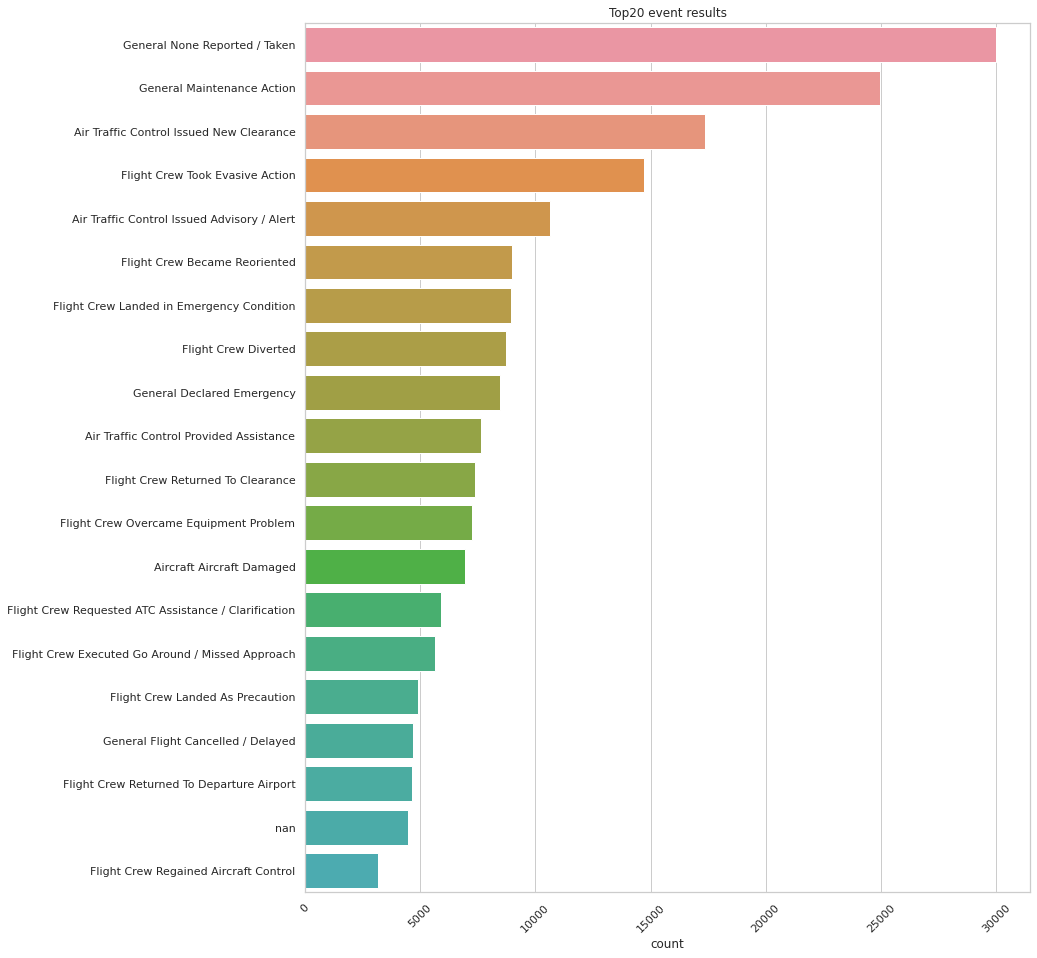

In [ ]:
# Countplot:
fig = plt.figure(figsize= (13,16))

sns.countplot(y = result, 
              order= pd.Series(result).value_counts().index,  # need to transform list to pd.Series for the ordering in countplot()
              orient = 'h')

# Plot the 20 most frequent occurences
topX = 20
plt.ylim(topX - 0.5)

plt.xticks(rotation=45)
plt.title('Top20 event results');

### Human Factors

In [ ]:
# TAKES ABOUT 2min. to EXECUTE 
# Make a list of all 'Human Factor' entries by spliting at each ';'
hum_facts = list()
for entry in df['Human Factors']:
    split = str(entry).split(sep = '; ') # include a space after ';'
    hum_facts = hum_facts + split

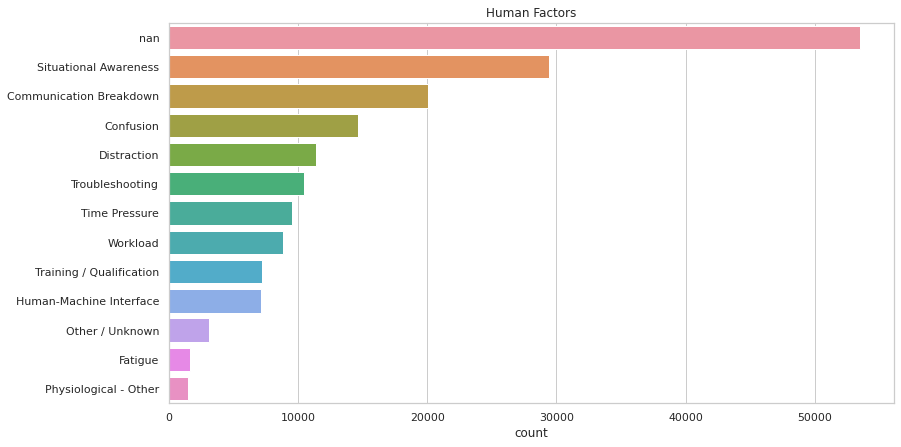

In [ ]:
# Countplot:
fig = plt.figure(figsize= (13,7))

# # Plot in decreasing order
sns.countplot(y = hum_facts, 
              order= pd.Series(hum_facts).value_counts().index, # need to transform list to pd.Series for the ordering in countplot()
              orient = 'h') 
plt.title('Human Factors');

### 'Contributing Factors', 'Primary Problem'

Examine the most common 'Contributing Factors / Situations' per 'Primary Problem'

In [ ]:
print("There are", df.isna().sum()['Primary Problem'], "entries with Primary Problem == NaN.")

There are 449 entries with Primary Problem == NaN.


In [ ]:
# List of all Primary Problems in the dataset
# exclude the entries, where 'Primary Problem is NaN'
prim_probs = list(df[df['Primary Problem'].isna() == False]['Primary Problem'].unique())

In [ ]:
contr_fact = list(df['Contributing Factors / Situations'].unique())
print(f"There are {len(contr_fact)} different 'Contributing Factors / Situations'")
contr_fact

There are 6920 different 'Contributing Factors / Situations'


['Human Factors',
 'Weather; Human Factors; Procedure',
 'Procedure; Human Factors',
 'Procedure',
 'ATC Equipment / Nav Facility / Buildings; Airport; Human Factors; Weather',
 'Human Factors; Procedure',
 'ATC Equipment / Nav Facility / Buildings; Aircraft; Procedure',
 'Aircraft; Procedure',
 'Airport; Human Factors; Procedure',
 'Aircraft; Human Factors; Procedure',
 'ATC Equipment / Nav Facility / Buildings; Human Factors; Procedure',
 'Procedure; Aircraft; Environment - Non Weather Related',
 'Human Factors; Aircraft; ATC Equipment / Nav Facility / Buildings; Weather',
 'Procedure; Human Factors; Company Policy; Airport',
 'Environment - Non Weather Related; Procedure',
 'Aircraft; Chart Or Publication; Human Factors; Procedure',
 'Airport; Environment - Non Weather Related; Procedure',
 'Weather; Chart Or Publication; Human Factors',
 'ATC Equipment / Nav Facility / Buildings',
 'Aircraft',
 'Chart Or Publication',
 'Procedure; Human Factors; Airspace Structure',
 'Aircraft; Pro


There are 45814 issues with Human Factors being the Primary Problem.
Among the 45814 issues with Human Factors being the Primary Problem, there are 9 NaN's under 'Contributing Factors / Situations'.

There are 9028 issues with Ambiguous being the Primary Problem.
Among the 9028 issues with Ambiguous being the Primary Problem, there are 4 NaN's under 'Contributing Factors / Situations'.

There are 7833 issues with Procedure being the Primary Problem.
Among the 7833 issues with Procedure being the Primary Problem, there are 0 NaN's under 'Contributing Factors / Situations'.

There are 25953 issues with Aircraft being the Primary Problem.
Among the 25953 issues with Aircraft being the Primary Problem, there are 9 NaN's under 'Contributing Factors / Situations'.

There are 1624 issues with ATC Equipment / Nav Facility / Buildings being the Primary Problem.
Among the 1624 issues with ATC Equipment / Nav Facility / Buildings being the Primary Problem, there are 0 NaN's under 'Contributing F

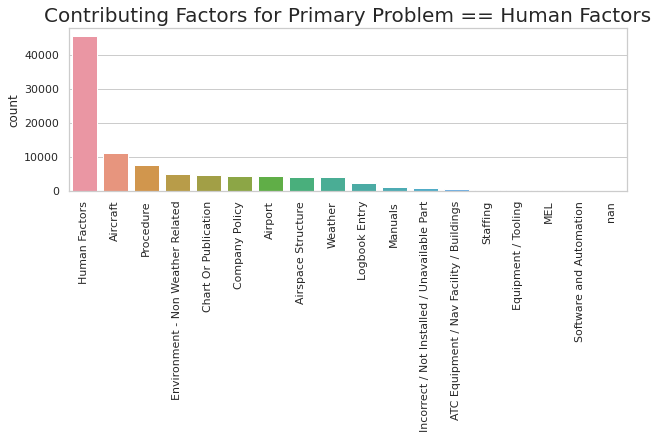

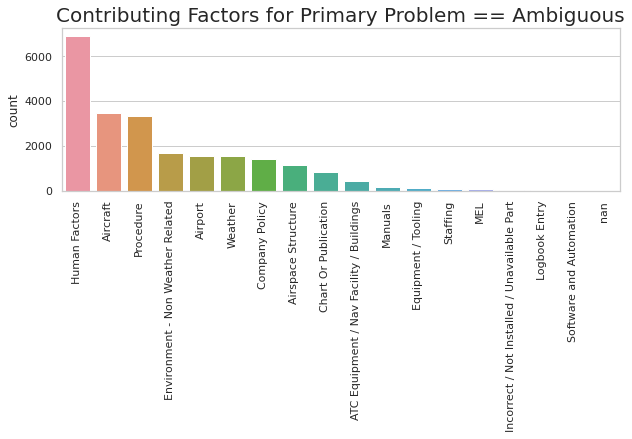

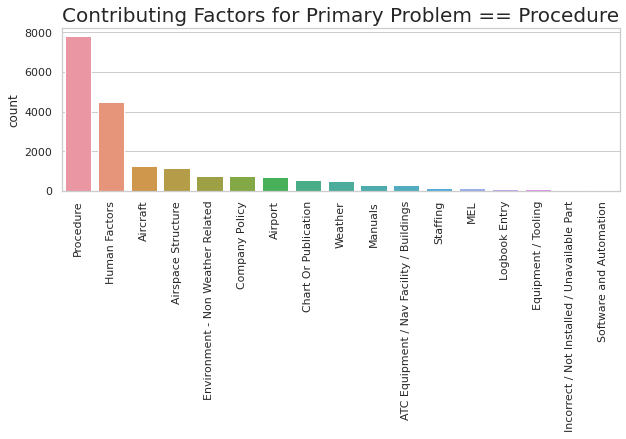

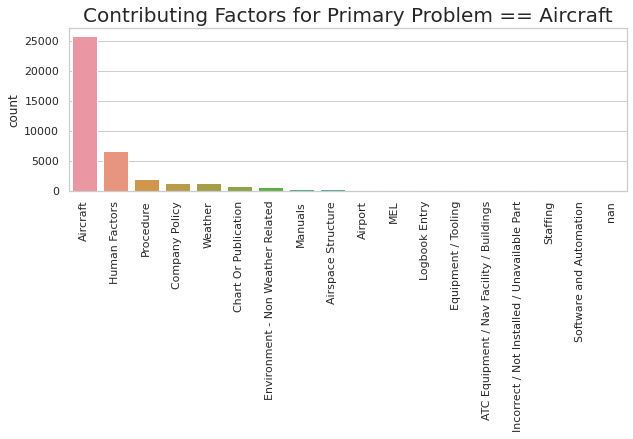

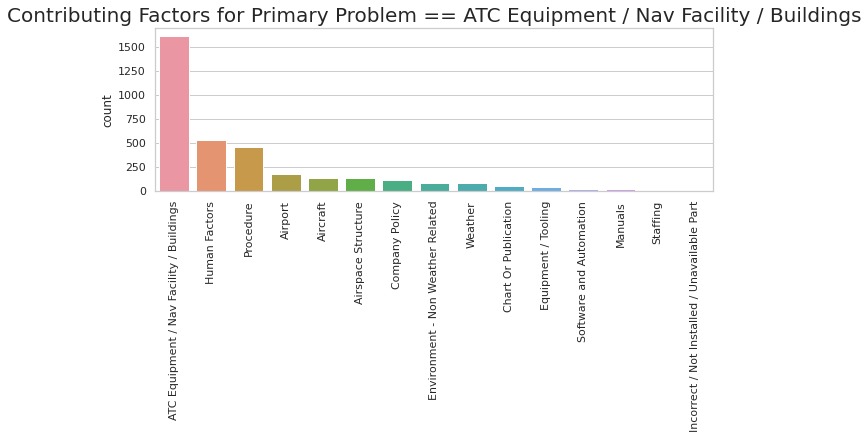

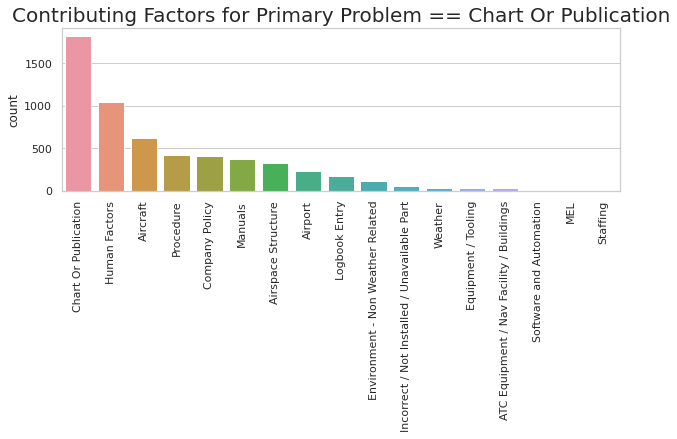

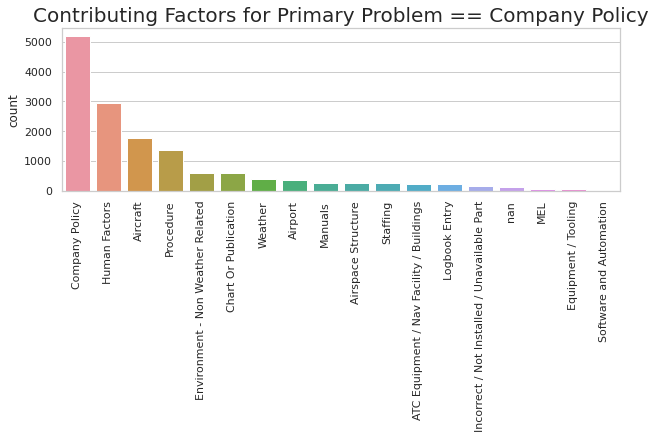

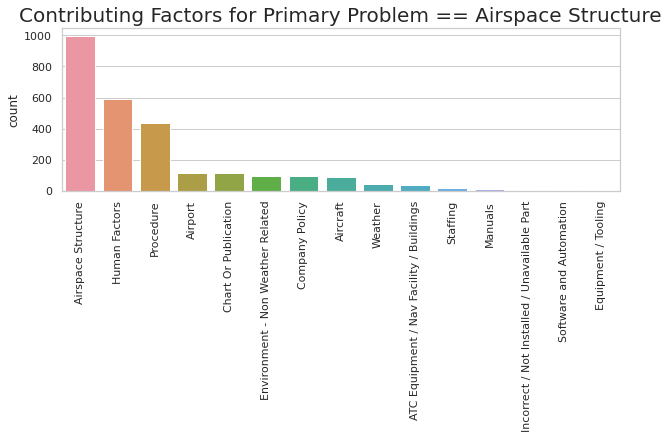

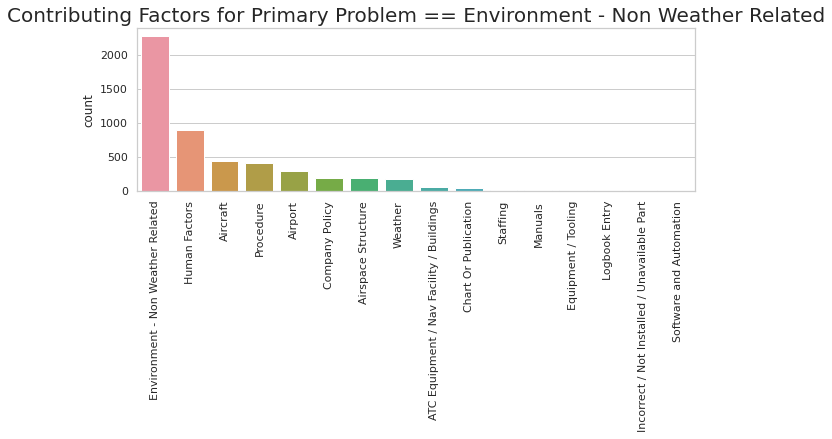

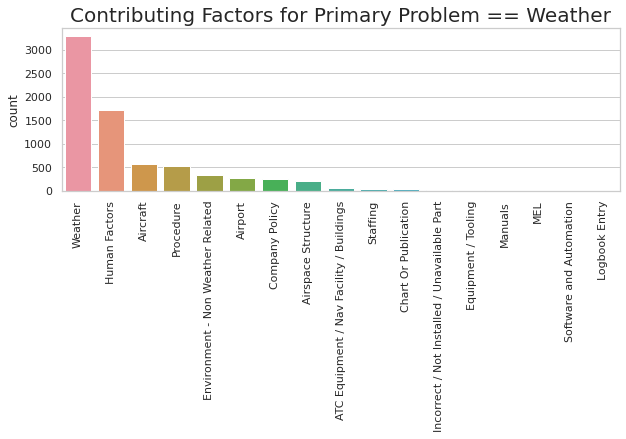

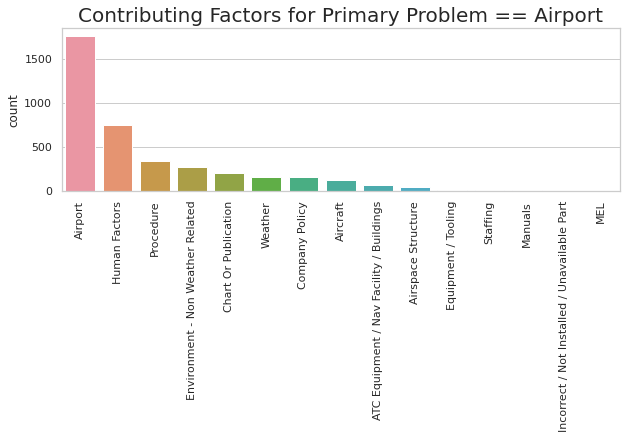

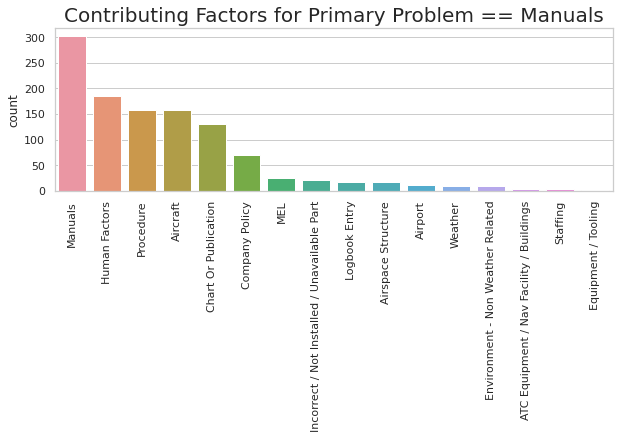

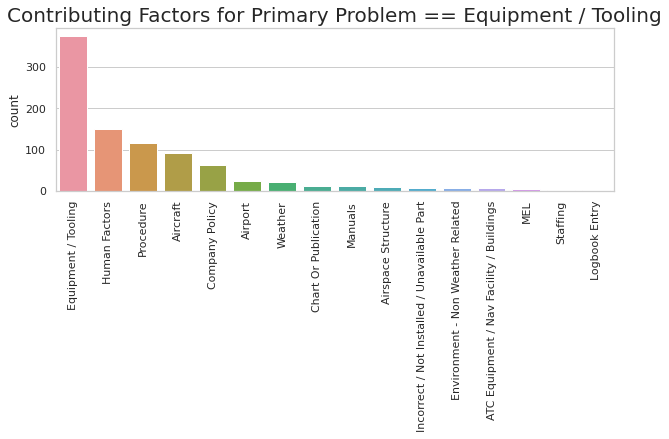

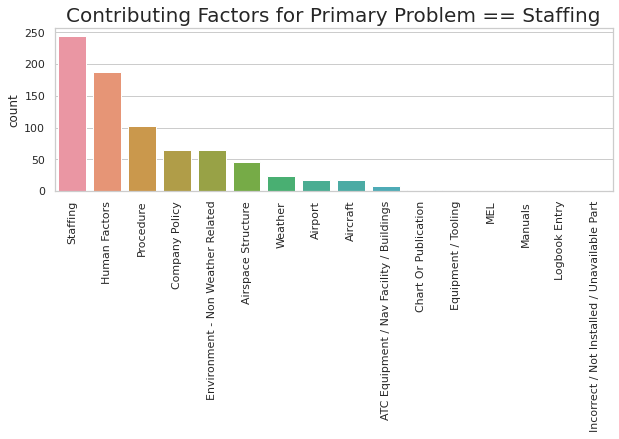

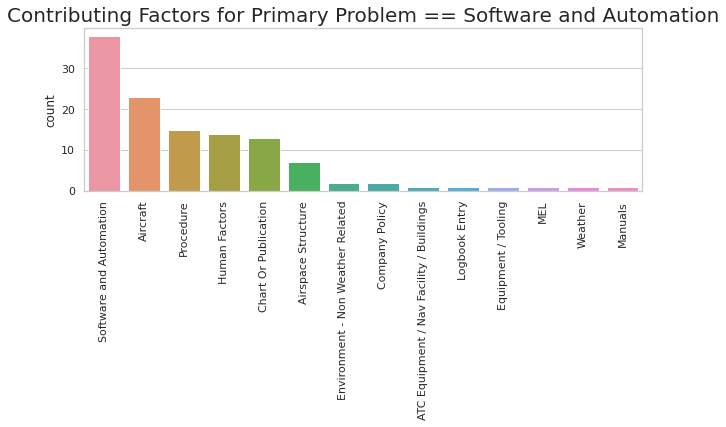

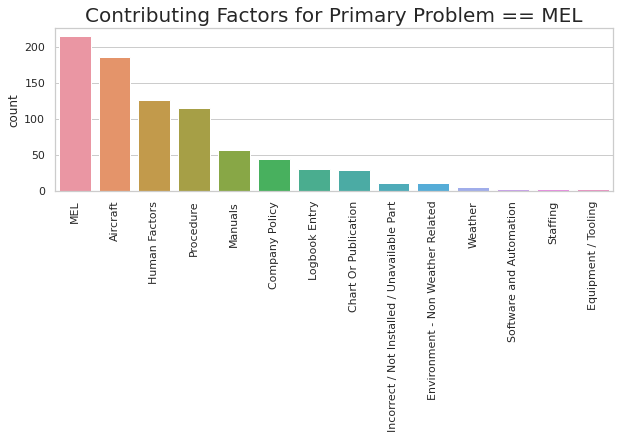

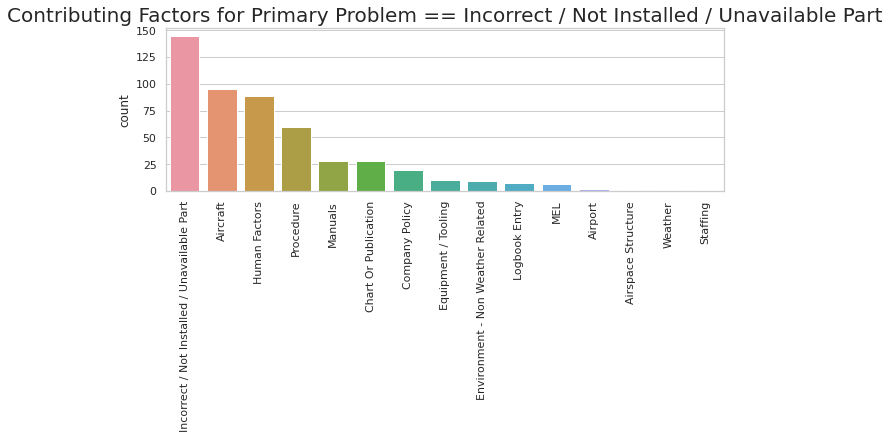

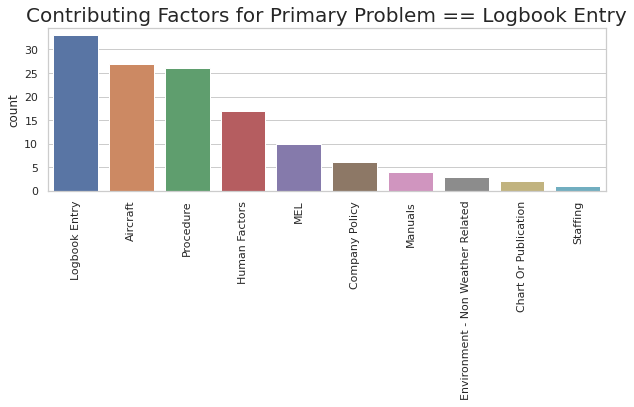

In [ ]:
#plt.rcParams.update({'figure.max_open_warning': 0});

for problem in prim_probs:
    
    # Select the data corresponding to a particular Primary Problem
    df_prob = df[df['Primary Problem'] == problem]
    
    print("\nThere are", len(df_prob), "issues with", problem, "being the Primary Problem.")
    print("Among the", len(df_prob), "issues with", problem, "being the Primary Problem, there are", 
          df_prob["Contributing Factors / Situations"].isna().sum(), "NaN's under 'Contributing Factors / Situations'.")
    
    # Make a list of all Contributing Factors for a given Primary Problem:
    cf = list()
    for contr_fact in df_prob['Contributing Factors / Situations']:
        contr_fact = str(contr_fact) # force into string format, because there was an error 'float does not have ';' separator'
        split = contr_fact.split(sep = '; ') # include a space after ';'
        cf = cf + split
        
    #print("For", problem, "the contributing factors are:", set(cf))
    
    # Countplot for the Contributing Factors
    fig = plt.figure(figsize= (10,3))
    sns.countplot(x = cf, order= pd.Series(cf).value_counts().index) # need to transform list to pd.Series for the ordering in countplot()
    plt.xticks(rotation=90)
    plt.title('Contributing Factors for Primary Problem == ' + problem, fontsize=20);

# FOCUS ON NARRATIVES

#### Examples

In [ ]:
# Set pandas settings to display full text columns
pd.options.display.max_colwidth = None

In [ ]:
df[['Narrative','Anomaly']].head(20)

Narrative  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## YANNIS: Narrative length

In [ ]:
# Create new column in df
df['narr_len'] = df['Narrative'].apply(lambda x: len(x))

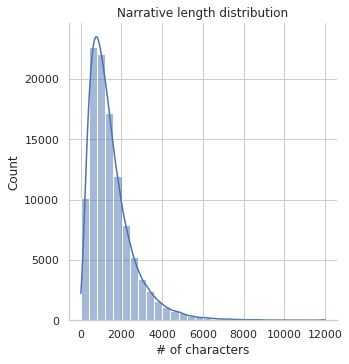

In [ ]:
# Plot
sns.displot(df['narr_len'], bins = 30, kde = True)
plt.xlabel('# of characters')
plt.title('Narrative length distribution');

### Only entries with 2 narratives

In [ ]:
# Write the database entries that contain 2 narratives, i.e. Narrative.1 is not empty
# into a separate DataFrame 
nar1_all = df[df['Narrative.1'].isna() == False]
print(f"There are {len(nar1_all)} entries where 'Narrative.1' is not empty.")

There are 14825 entries where 'Narrative.1' is not empty.


In [ ]:
# Create new column in 'nar1_all' DataFrame
# nar1_all['narr_len'] = pd.Series([len(entry) for entry in nar1_all['Narrative']])
nar1_all['narr_len'] = nar1_all['Narrative'].apply(lambda x: len(x))
# nar1_all['narr1_len'] = pd.Series([len(entry) for entry in nar1_all['Narrative.1']])
nar1_all['narr1_len'] = nar1_all['Narrative.1'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


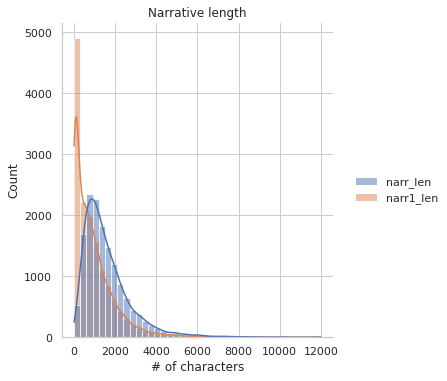

In [ ]:
# Plot
sns.displot([nar1_all['narr_len'], nar1_all['narr1_len']],
            bins = 40, kde = True)
plt.xlabel('# of characters')
plt.title('Narrative length');

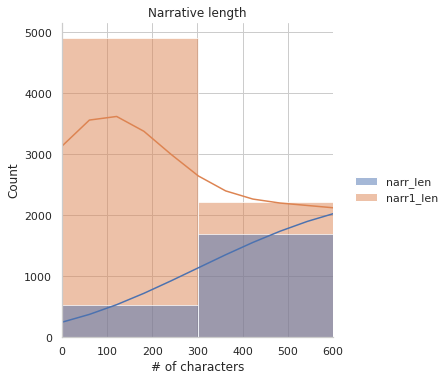

In [ ]:
# Plot (zoom)
sns.displot([nar1_all['narr_len'], nar1_all['narr1_len']],
            bins = 40, kde = True)
plt.xlabel('# of characters')
plt.title('Narrative length')
plt.xlim([0, 600]);

In [ ]:
# Examine the short 'Narrative.1' entries
# short_narr = [entry for entry in nar1_all[nar1_all['narr1_len'] < 300 ]['Narrative.1']]
short_narr = nar1_all[nar1_all['narr1_len'] < 300 ]#['Narrative.1']
short_narr[['Narrative.1','narr1_len']].head(10)

Narrative.1  \
45                                                                                                                                                                                                    [Report narrative contained no additional information.]   
64   I don't have all the details. I was working CIC/FD/CD and trying to coordinate what was exactly being closed and opened with airport at the time. The airport did not seem to know what they were going to open and close when it came to surface areas.   
107                                                                                                                                                                                                   [Report narrative contained no additional information].   
128                                                                                                      The red light / green light with MRI has been an item of concern for at least 4 years; several fixes have been attempted; and all have had failures.   
173                                                                                                                                                                                                   [Report narrative contained no additional information.]   
183                                                                              As a crew we were not sure if SLOP is/was required or an option on said route. We still don't know. We entered SLOP because it is [Company] FOM procedure on Oceanic routes.   
189                                On climbout was given 3000 feet. Lead aircraft continued climbing in accordance with departure as is usually the case. Was told to level off at 6000 feet. Lead aircraft was told that it was due to 'loss of separation'.   
211                                                                                                                                                                                                   [Report narrative contained no additional information.]   
213                                                                                                                                                                                                   [Report narrative contained no additional information.]   
221                                                                                                                                                                                                   [Report narrative contained no additional information.]   

     narr1_len  
45          55  
64         248  
107         55  
128        148  
173         55  
183        172  
189        218  
211         55  
213         55  
221         55

In [ ]:
# Count how many 'Narrative.1' contain the word 'narrative' or 'Narrative'
my_list1 = [entry for entry in nar1_all['Narrative.1'] 
            if ('Narrative' in entry or 'narrative' in entry)
            ]
len(my_list1)

3437

## YANNIS: WordCloud

In [ ]:
# Write all *main* narratives of the dataset into a single string 
all_nar = ''
all_nar = ' '.join(str(entry) for entry in df['Narrative'])
len(all_nar) # length in characters

160209560

In [ ]:
# Define stop word list
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) 
# we convert it to a set, more efficient (vs. a liste) for the stopword-filtering later 
# 'set' also avoids duplicates

# add additional stop words: 
stop_words.update(['.', ';', '[', ']'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


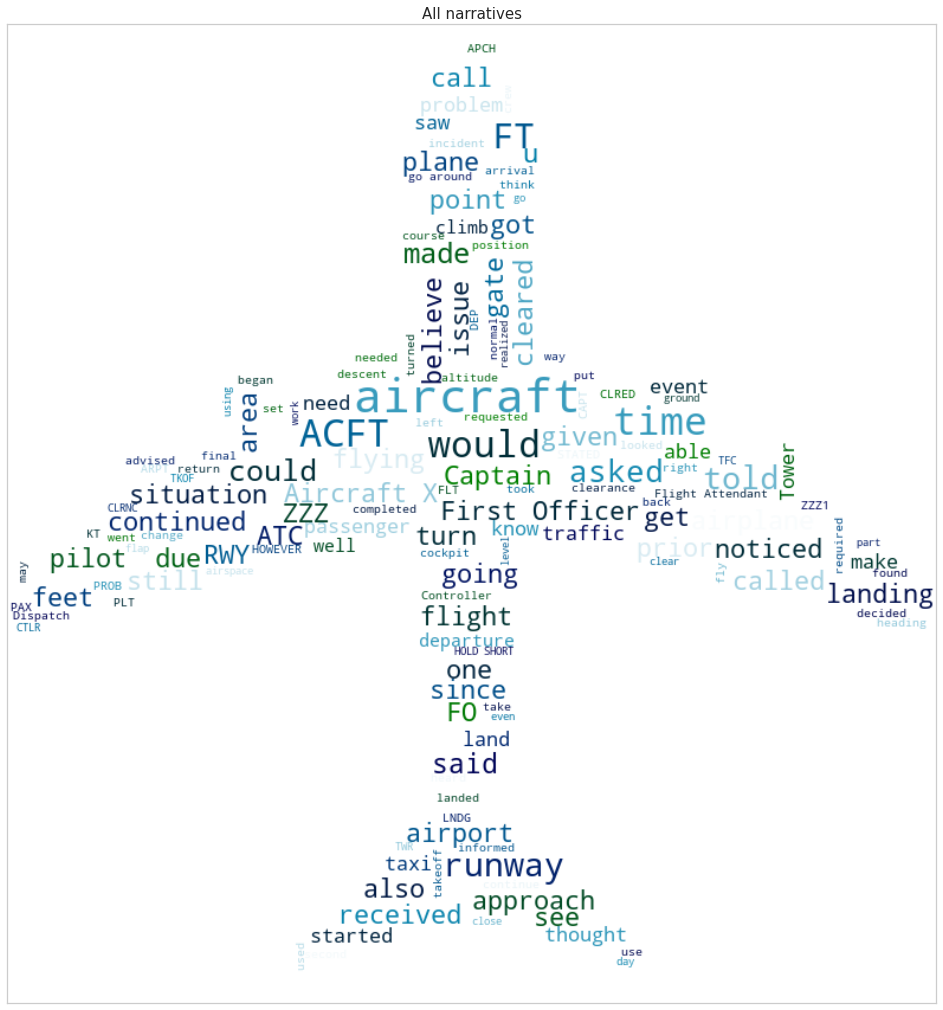

In [ ]:
fig = plt.figure(figsize = (18, 18))
plot_word_cloud(all_nar, 'All narratives', stop_words, "plane.png")

## Narratives : case style clustering

#### Defining 6 features for Case style clustering 
- Nbr of words (2+ letters)
- Starting words / Following words in  lowercase / UPPERCASE / Capital letter 

In [ ]:
def Tokenizing_KPIs(text):
    Sent_tokenizer=PunktSentenceTokenizer()
    sentences=Sent_tokenizer.tokenize(text)
    nb_sentences=len(sentences)
    
    sentence_tokens=[]
    starting_tokens_str=''
    following_tokens=[]
    for sentence in sentences:
        tokenizer = TweetTokenizer() 
        tokens = tokenizer.tokenize(sentence)
        sentence_tokens.append(tokens)
        starting_tokens_str=starting_tokens_str+' '+tokens[0]
        following_tokens.append(tokens[1:])
    following_tokens_str=''
    for i in range(len(sentences)):
        for j in range(len(following_tokens[i])):
            following_tokens_str=following_tokens_str+' '+following_tokens[i][j]
    # Starting words :
    # in UPPER CASE (2+ letters) : we don't count 1 letter words in capital : could be 'I' or a 1-letter abbrev (L R N S E W ...)
    nb_UPPERCASE_startingwords = len(re.findall(r"\b[A-Z][A-Z]+\b",  starting_tokens_str ))
    # in Capital letter (2+ letters) : we don't count 1 letter words in capital : could be 'I' or a 1-letter abbrev (L R N S E W ...)
    nb_Capital_startingwords = len(re.findall(r"\b[A-Z][a-z]+\b",  starting_tokens_str ))
    # in lower letter
    nb_lowercase_startingwords = len(re.findall(r"\b[a-z]+\b",  starting_tokens_str ))

    # Following words :
    # in UPPER CASE (2+ letters) : we don't count 1 letter words in capital : could be 'I' or a 1-letter abbrev (L R N S E W ...)
    nb_UPPERCASE_follwords = len(re.findall(r"\b[A-Z][A-Z]+\b",  following_tokens_str ))
    # in Capital letter (2+ letters) : we don't count 1 letter words in capital : could be 'I' or a 1-letter abbrev (L R N S E W ...)
    nb_Capital_follwords = len(re.findall(r"\b[A-Z][a-z]+\b",  following_tokens_str ))
    # in lower letter
    nb_lowercase_follwords = len(re.findall(r"\b[a-z]+\b",  following_tokens_str ))

    return  [nb_sentences,nb_UPPERCASE_startingwords,nb_Capital_startingwords,nb_lowercase_startingwords,nb_UPPERCASE_follwords,nb_Capital_follwords,nb_lowercase_follwords]

#### Defining Lower/Uppercase features on the whole dataset
- Following cell : approx 8 mn

In [ ]:
heure_debut = time() 

df['KPIs']=df['Narrative'].apply(lambda x: Tokenizing_KPIs(x))

heure_fin = time()
temps = heure_fin - heure_debut
print("Calculation took", temps/60, "mns")
# TAKES SEVERAL MINUTES TO RUN

Calculation took 4.446691795190175 mns


In [ ]:
columns_Case_style=['Nb Sentences',
         'nb_UPPERCASE_startingwords', 'nb_Capital_startingwords','nb_lowercase_startingwords',
         'nb_UPPERCASE_follwords','nb_Capital_follwords','nb_lowercase_follwords']
for i,col in enumerate(columns_Case_style) :
    df[col]=df['KPIs'].apply(lambda x: x[i])

df=df.drop('KPIs',axis=1)

In [ ]:
df['nb_total_startingwords']=(df['nb_UPPERCASE_startingwords']+df['nb_Capital_startingwords']+df['nb_lowercase_startingwords'])
df['nb_total_follwords']=(df['nb_UPPERCASE_follwords']+df['nb_Capital_follwords']+df['nb_lowercase_follwords'])

#### Nbr of sentences analysis

In [ ]:
df[columns_Case_style].describe().T

count        mean         std  min  25%   50%  \
Nb Sentences                108241.0   14.625401   10.271471  1.0  8.0  12.0   
nb_UPPERCASE_startingwords  108241.0    4.745614    7.419616  0.0  0.0   1.0   
nb_Capital_startingwords    108241.0    6.729077    8.266672  0.0  0.0   5.0   
nb_lowercase_startingwords  108241.0    0.115428    0.493826  0.0  0.0   0.0   
nb_UPPERCASE_follwords      108241.0   91.793646  147.329885  0.0  4.0  15.0   
nb_Capital_follwords        108241.0    6.215223   10.459656  0.0  0.0   2.0   
nb_lowercase_follwords      108241.0  143.995140  186.510275  0.0  0.0  90.0   

                              75%     max  
Nb Sentences                 19.0   148.0  
nb_UPPERCASE_startingwords    8.0   112.0  
nb_Capital_startingwords     11.0    98.0  
nb_lowercase_startingwords    0.0    20.0  
nb_UPPERCASE_follwords      136.0  2020.0  
nb_Capital_follwords          9.0   330.0  
nb_lowercase_follwords      223.0  2079.0

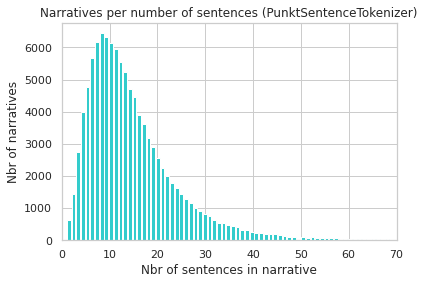

In [ ]:
plt.hist(df['Nb Sentences'],  bins = 150, rwidth=0.8,color='#33cccc')
plt.title('Narratives per number of sentences (PunktSentenceTokenizer)')
plt.xlim((0,70))
plt.xlabel('Nbr of sentences in narrative')
plt.ylabel('Nbr of narratives');


In [ ]:
#Narrative having the maximum of sentences (283): we can see that the nb of sentences is overrated due to '....'
print(max(df['Nb Sentences']))
df[df['Nb Sentences']==max(df['Nb Sentences'])]['Narrative']

148


95390    FO FLYING. ON ROTATION AND LIFTOFF WITH A POSITIVE RATE FO CALLED FOR GEAR UP. AS I REACHED FOR THE GEAR LEVER MY PFD; ND AND UPPER ECAM WENT BLANK. BROUGHT GEAR HANDLE UP; BUT COULD TELL GEAR DID NOT COME UP. NO AUDIO WARNINGS GOING OFF DUE TO INHIBITS. STATED THAT I HAD AN ELECTRICAL FAILURE TO FO AND FOR HIM TO KEEP FLYING. I LOOKED TO HIS PFD AND ND AND HIS WAS STILL WORKING. ALSO NOTICED THAT HE HAD THE MESSAGE 'USE MANUAL PITCH TRIM' ON HIS PFD. SAID TO HIM THAT HE WAS IN DIRECT LAW AND WOULD HAVE TO TRIM MANUALLY. WE DECIDED TO CONTINUE ON THE HEADING ASSIGNED BY TWR ON TKOF AND CLIMB TO OUR FIRST CLRED ALTITUDE WHILE CLEANING UP THE ACFT. AS WE LEVELED AT 2500 FT MSL I SAID TO FO THAT HE WOULD NEED TO USE MANUAL THROTTLES; WHICH HE DID. WE LEVELED AT 2500 FT MSL. AS WE WERE CLEANING UP I WAS WATCHING THE ECAM'S ON THE LOWER ECAM. THEY WERE DANCING. ONE WOULD COME UP THEN MOVE OR GO AWAY AND ANOTHER ONE APPEAR. AS WE LEVELED OFF; ONE ECAM PROC STAYED ON TOP SO I DID IT.

In [ ]:
print('# narratives with nb_total_startingwords=0 : ',sum(df['nb_total_startingwords']==0))
print('# narratives with nb_total_follwords=0 : ',sum(df['nb_total_follwords']==0))

# narratives with nb_total_startingwords=0 :  274
# narratives with nb_total_follwords=0 :  0


In [ ]:
df['pct_UPPERCASE_startingwords']=df['nb_UPPERCASE_startingwords']/df['nb_total_startingwords']
df['pct_Capital_startingwords']=df['nb_Capital_startingwords']/df['nb_total_startingwords']
df['pct_lowercase_startingwords']=df['nb_lowercase_startingwords']/df['nb_total_startingwords']

df['pct_UPPERCASE_startingwords']=df['pct_UPPERCASE_startingwords'].fillna(0)
df['pct_Capital_startingwords']=df['pct_Capital_startingwords'].fillna(0)
df['pct_lowercase_startingwords']=df['pct_lowercase_startingwords'].fillna(0)

df['pct_UPPERCASE_follwords']=df['nb_UPPERCASE_follwords']/df['nb_total_follwords']
df['pct_Capital_follwords']=df['nb_Capital_follwords']/df['nb_total_follwords']
df['pct_lowercase_follwords']=df['nb_lowercase_follwords']/df['nb_total_follwords']

In [ ]:
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restaure pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

In [ ]:
columns_Case_style2=['Narrative','Nb Sentences','nb_UPPERCASE_startingwords', 'nb_Capital_startingwords','nb_lowercase_startingwords', 'nb_UPPERCASE_follwords','nb_Capital_follwords','nb_lowercase_follwords','nb_total_startingwords','nb_total_follwords','pct_UPPERCASE_startingwords','pct_Capital_startingwords','pct_lowercase_startingwords','pct_UPPERCASE_follwords','pct_Capital_follwords','pct_lowercase_follwords']

df[columns_Case_style2].head()

Narrative  Nb Sentences  \
0  A BE20 was inbound to ANC via YESKA. He was to...            17   
1  A C208 departed for Kenai. Kenai Tower called ...            18   
2  Descending into FAI. Cleared for Visual Approa...            14   
3  I had just assumed control of Sector 9. A C130...            32   
4  During approach to Runway 23; we received a ru...            21   

   nb_UPPERCASE_startingwords  nb_Capital_startingwords  \
0                           0                        11   
1                           0                        11   
2                           0                        11   
3                           1                        22   
4                           0                        21   

   nb_lowercase_startingwords  nb_UPPERCASE_follwords  nb_Capital_follwords  \
0                           0                       7                     1   
1                           0                       4                    20   
2                           0                       8                    13   
3                           0                      53                    23   
4                           0                      10                    14   

   nb_lowercase_follwords  nb_total_startingwords  nb_total_follwords  \
0                     162                      11                 170   
1                     311                      11                 335   
2                     141                      11                 162   
3                     446                      23                 522   
4                     485                      21                 509   

   pct_UPPERCASE_startingwords  pct_Capital_startingwords  \
0                     0.000000                   1.000000   
1                     0.000000                   1.000000   
2                     0.000000                   1.000000   
3                     0.043478                   0.956522   
4                     0.000000                   1.000000   

   pct_lowercase_startingwords  pct_UPPERCASE_follwords  \
0                          0.0                 0.041176   
1                          0.0                 0.011940   
2                          0.0                 0.049383   
3                          0.0                 0.101533   
4                          0.0                 0.019646   

   pct_Capital_follwords  pct_lowercase_follwords  
0               0.005882                 0.952941  
1               0.059701                 0.928358  
2               0.080247                 0.870370  
3               0.044061                 0.854406  
4               0.027505                 0.952849

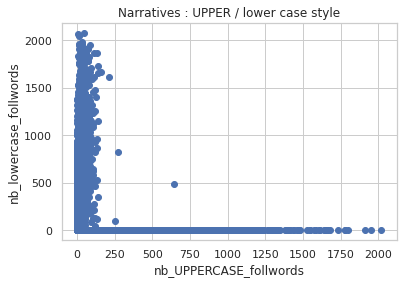

In [ ]:
plt.scatter(df['nb_UPPERCASE_follwords'], df['nb_lowercase_follwords'])
plt.title('Narratives : UPPER / lower case style')
plt.xlabel('nb_UPPERCASE_follwords')
plt.ylabel('nb_lowercase_follwords');


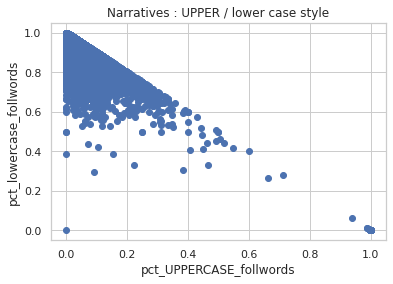

In [ ]:
plt.scatter(df['pct_UPPERCASE_follwords'], df['pct_lowercase_follwords'])
plt.title('Narratives : UPPER / lower case style')
plt.xlabel('pct_UPPERCASE_follwords')
plt.ylabel('pct_lowercase_follwords');

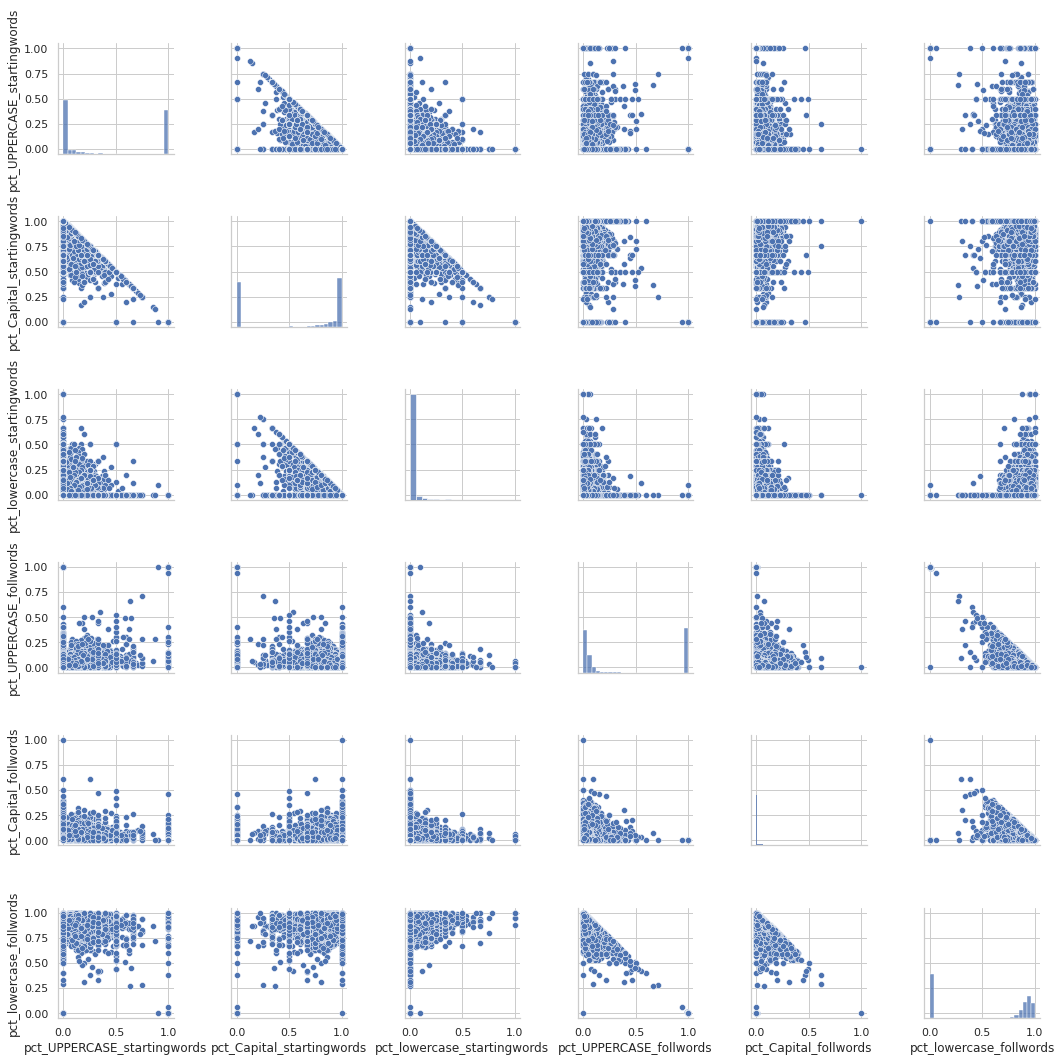

In [ ]:
# Découverte du lien entre les variables
#
sns.pairplot(df[['pct_UPPERCASE_startingwords', 'pct_Capital_startingwords','pct_lowercase_startingwords', 'pct_UPPERCASE_follwords','pct_Capital_follwords','pct_lowercase_follwords']]);

In [ ]:
ls_features= ['pct_UPPERCASE_startingwords', 'pct_Capital_startingwords','pct_lowercase_startingwords', 'pct_UPPERCASE_follwords','pct_Capital_follwords','pct_lowercase_follwords']
data_classif=df[ls_features]

In [ ]:
data_classif.describe().T

count      mean       std  min       25%  \
pct_UPPERCASE_startingwords  108241.0  0.410137  0.477758  0.0  0.000000   
pct_Capital_startingwords    108241.0  0.578675  0.472806  0.0  0.000000   
pct_lowercase_startingwords  108241.0  0.008657  0.037986  0.0  0.000000   
pct_UPPERCASE_follwords      108241.0  0.416894  0.471217  0.0  0.022727   
pct_Capital_follwords        108241.0  0.025261  0.035772  0.0  0.000000   
pct_lowercase_follwords      108241.0  0.557845  0.451972  0.0  0.000000   

                                  50%       75%  max  
pct_UPPERCASE_startingwords  0.058824  1.000000  1.0  
pct_Capital_startingwords    0.900000  1.000000  1.0  
pct_lowercase_startingwords  0.000000  0.000000  1.0  
pct_UPPERCASE_follwords      0.063830  1.000000  1.0  
pct_Capital_follwords        0.010554  0.040100  1.0  
pct_lowercase_follwords      0.878505  0.939759  1.0

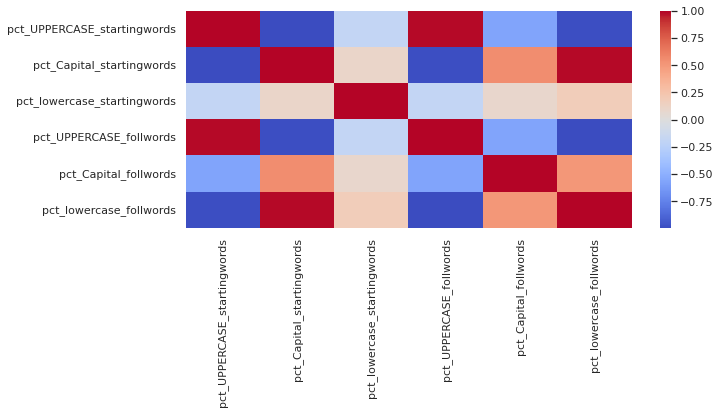

In [ ]:
sns.set(rc={'figure.figsize':(10,4)})
df_corr = data_classif.corr()
ax = sns.heatmap(df_corr, xticklabels = df_corr.columns , 
                 yticklabels = df_corr.columns, cmap = 'coolwarm')


### Clustering

In [ ]:
heure_debut = time() 


# Définition de la liste de n_clusters
range_n_clusters = [2, 3, 4, 5, 6]
#range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Initialisation de la liste pour graphique
distorsions = []

for k in range_n_clusters:
    # Algorithme de K-means
    cluster = KMeans(n_clusters = k)
    cluster.fit(data_classif)
    # Centroids and labels
    centroids = cluster.cluster_centers_
    # cdist calcule la distance de chaque point du df à chaque centroide = un vecteur de dimension k 
    # => on prend le min = la distance au centroide le plus proche
    distorsions.append(sum(np.min(cdist(data_classif, cluster.cluster_centers_, 'euclidean'),axis=1))/len(data_classif))


heure_fin = time()
temps = heure_fin - heure_debut
print("Calculation took", temps/60, "mns")


Calculation took 0.12230101029078165 mns


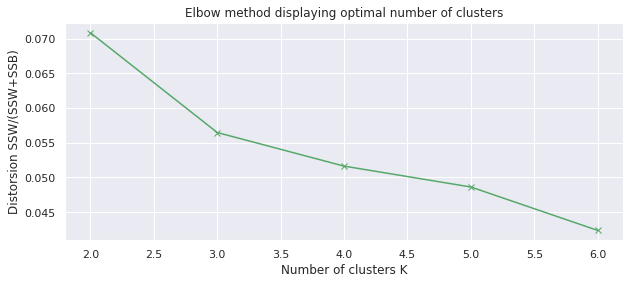

In [ ]:
plt.plot(range_n_clusters,distorsions,'gx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Distorsion SSW/(SSW+SSB)')
plt.title('Elbow method displaying optimal number of clusters')  # 3 clusters
plt.show()


In [ ]:
# Algorithme de K-means  
nb_clusters=3
kmeans=KMeans(n_clusters=nb_clusters)
kmeans.fit(data_classif)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
print(labels)


[[1.58354335e-01 7.70844089e-01 5.85119392e-02 5.57447369e-02
  4.36847656e-02 9.00570498e-01]
 [9.96155973e-01 2.27444643e-05 2.34290802e-06 9.99830080e-01
  2.72537645e-05 1.42665930e-04]
 [7.87971988e-03 9.84894713e-01 7.22556676e-03 3.44394684e-02
  4.13711202e-02 9.24189411e-01]]
[2 2 2 ... 1 1 1]


In [ ]:
df_labels=pd.DataFrame(labels).rename(columns={0:'Style Cluster'})
# Fusion avec notre dataset de Kmeans
data_classif=pd.concat( [data_classif ,df_labels] ,  axis = 1)
data_classif['Style Cluster']=data_classif['Style Cluster'].astype('str')


In [ ]:
# Fusion avec notre dataset de narratifs
df=pd.concat( [df ,df_labels] ,  axis = 1)
df['Style Cluster']=df['Style Cluster'].astype('str')

In [ ]:
data_classif['Style Cluster'].value_counts()

2    56631
1    42682
0     8928
Name: Style Cluster, dtype: int64

<Figure size 432x432 with 0 Axes>

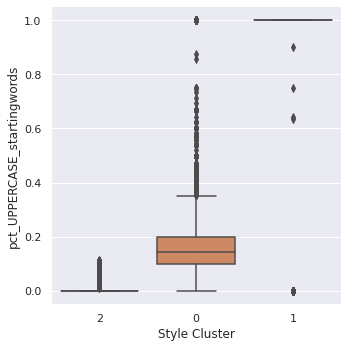

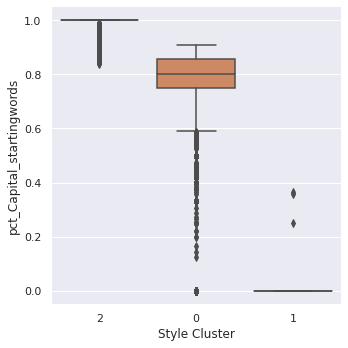

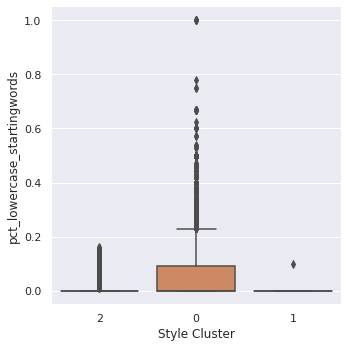

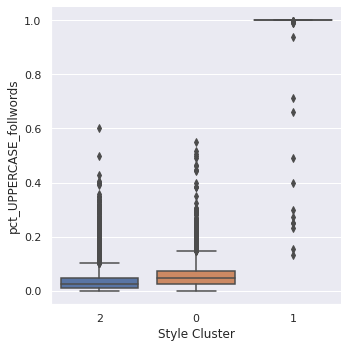

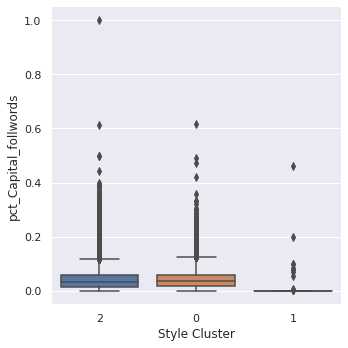

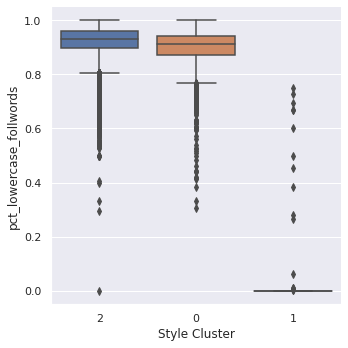

In [ ]:
# ANALYSE PAR VARIABLE
# Diagramme en boîte (boxplot) de toutes les variables explicatives
fig = plt.figure(figsize=(6,6))
for i, feature in enumerate(ls_features) :
    sns.catplot(data=data_classif,x='Style Cluster',y=feature,kind ='box' );


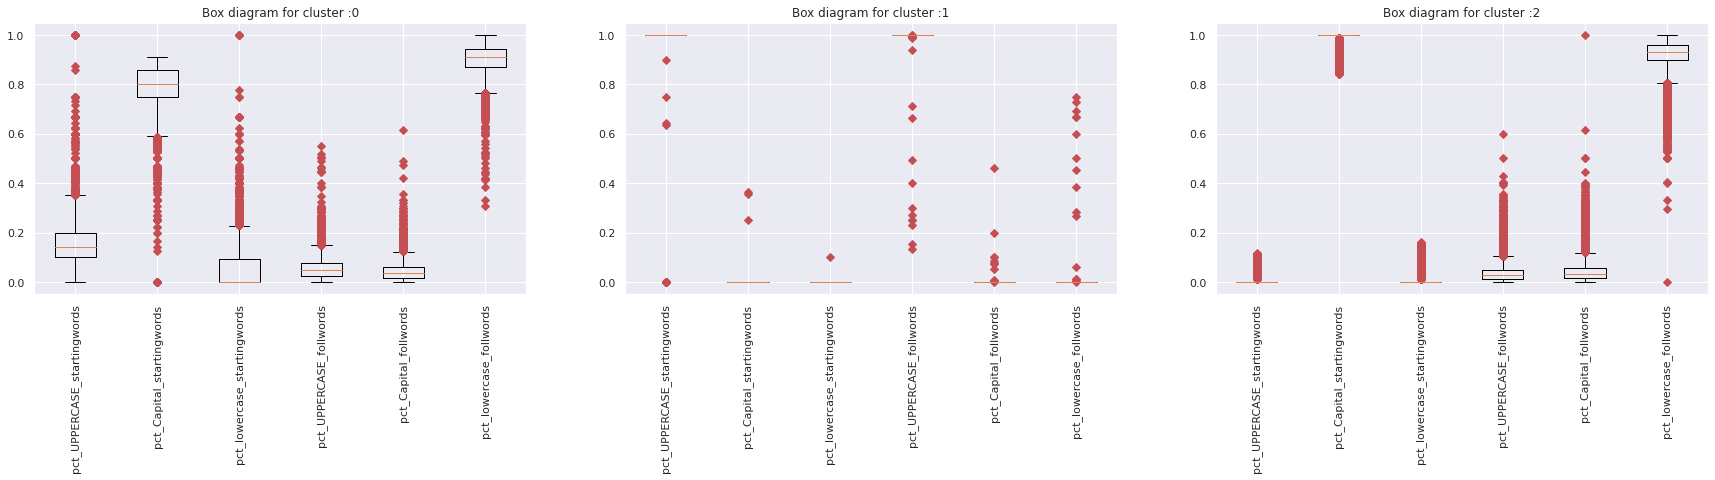

In [ ]:
plt.figure(figsize=(30, 5))
for clust in range(0,3) :
    plt.subplot(1,3,clust+1)
    df_plot=data_classif[data_classif['Style Cluster']==str(clust)]
    plt.title('Box diagram for cluster :'+str(clust))
    plt.boxplot(df_plot[ls_features].values, 0, 'rD', labels = ls_features)
    plt.xticks(rotation=90)
plt.show()


In [ ]:
# Set pandas settings to display full text columns
pd.options.display.max_colwidth = None
df[(df['Style Cluster']=='2')&(df['Nb Sentences']<=6)]['Narrative'].head(20)

6                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             At cruise FL320.  Received CPDLC message from PAZN to contact Anchorage Center 132.85.  Multiple attempts were made with no success; while passing within 20 miles south [of] CDB.  Multiple other aircraft all seemed to have the same difficulty.  Contact was maintained with PAZN CPDLC at all times.
16              

In [ ]:
# Restaure pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108241 entries, 0 to 108240
Columns: 116 entries, Date to Style Cluster
dtypes: bool(1), float64(21), int64(12), object(82)
memory usage: 99.9+ MB


In [ ]:
df['Style Cluster_lbl']=df['Style Cluster'].replace(to_replace=['0','1','2'], value=['lower','upper','mix'])


In [ ]:
df['Style Cluster_lbl'].value_counts()

mix      56631
upper    42682
lower     8928
Name: Style Cluster_lbl, dtype: int64

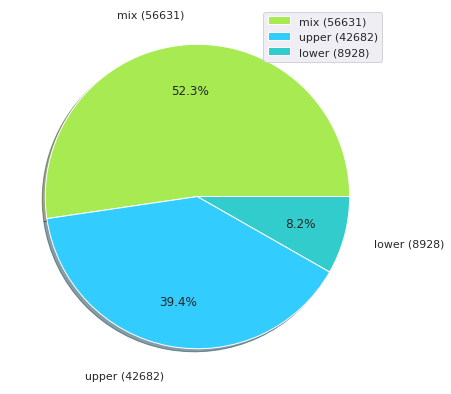

In [ ]:
df_plot=pd.DataFrame(df['Style Cluster_lbl'].value_counts())

df_plot['index_vol']=df_plot.index.astype(str) + ' (' +df_plot['Style Cluster_lbl'].astype(str)+ ')'

df_plot
plt.figure( figsize= (7, 7) )
plt.pie(df_plot['Style Cluster_lbl']
        , labels = df_plot.index_vol
        ,colors=['#a7ea52', '#33ccff', '#33cccc']
        ,labeldistance =1.2  
        #,explode=[0, 0,0, 0.2, 0, 0]
     ,autopct = lambda x: str(round(x, 1)) + '%'
        ,pctdistance=0.7
        ,shadow =True )
plt.legend();       


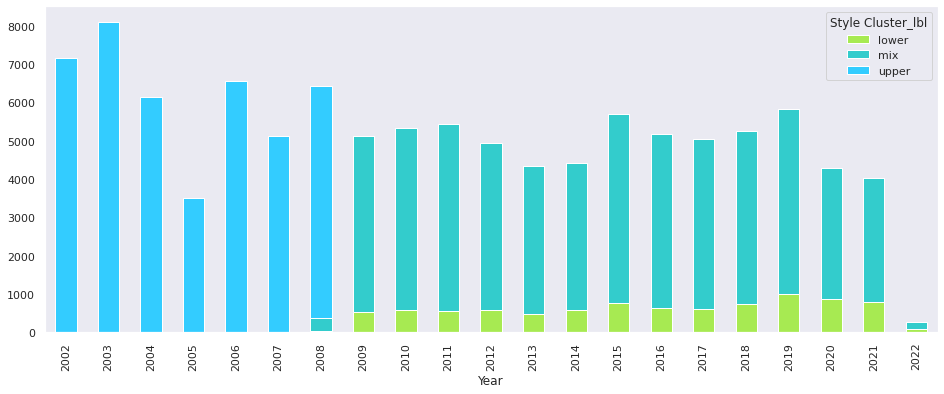

In [ ]:
df_plot = df.groupby(['Year','Style Cluster_lbl']).size().reset_index().pivot(columns='Style Cluster_lbl', index='Year', values=0)
fig, ax = plt.subplots(figsize=(16,6))
df_plot.plot(kind='bar', color=['#a7ea52', '#33cccc', '#33ccff'], stacked=True,ax=ax)
plt.grid(False);


## Abbreviations

### Looking for Narratives with both forms (Abbreviations and Full-text) of the same word/expression

In [ ]:
# Set pandas settings to display full text columns
pd.options.display.max_colwidth = None

#### Example 1 : aircraft / ACFT  
We voluntary chose an abbreviation which can't be contained in a common word , as we are currently using 'in' and not Regex to find the abbreviation in the Narrative (i.e. air carrier / ACR wouldn't be a good example as ACR could be contained in 'acrobaty' for instance)

In [ ]:
df['Narrative_aircraft']=df['Narrative'].apply(lambda x: 1 if ('aircraft' in x.lower()) else 0)
df['Narrative_ACFT']=df['Narrative'].apply(lambda x: 1 if ('ACFT' in x.upper()) else 0)
df['Narrative_aircraft/ACFT']=df['Narrative'].apply(lambda x: 1 if (('aircraft' in x.lower()) or ('ACFT' in x.upper()) )else 0)

In [ ]:
df[df['Narrative_aircraft']==1]['Narrative'].head(10)
# All narratives in head appears to be written in lower case letters  => to be checked

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
df[df['Narrative_ACFT']==1]['Narrative'].head(10)
# All narratives in head appears to be written mostly in upper case letters   => to be checked

315                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
pd.crosstab(df['Narrative_aircraft'],df['Narrative_ACFT'])

Narrative_ACFT          0      1
Narrative_aircraft              
0                   38424  26225
1                   43419    173

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_ACFT'])

Narrative_ACFT         0      1
Style Cluster_lbl              
lower               8915     13
mix                56604     27
upper              16324  26358

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_aircraft'])

Narrative_aircraft      0      1
Style Cluster_lbl               
lower                3422   5506
mix                 18969  37662
upper               42258    424

#### Example 2 : air traffic control / ATC

We voluntary chose an abbreviation which can't be contained in a common word , as we are currently using 'in' and not Regex to find the abbreviation in the Narrative (i.e. air carrier / ACR wouldn't be a good example as ACR could be contained in 'acrobaty' for instance)

In [ ]:
df['Narrative_air_traffic_control']=df['Narrative'].apply(lambda x: 1 if ('air traffic control' in x.lower()) else 0)
df['Narrative_ATC']=df['Narrative'].apply(lambda x: 1 if ('ATC' in x.upper()) else 0)

In [ ]:
df[df['Narrative_air_traffic_control']==1]['Narrative'].head(10)
# All narratives in head appears to be written in lower case letters  => to be checked

55                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
df[df['Narrative_ATC']==1]['Narrative'].head(10)
# All narratives in head appears to be written mostly in upper case letters   => to be checked

3     I had just assumed control of Sector 9. A C130 was on the ILS/D Z Runway 25 approach at ADQ. A Dash 8 had been issued holding at CHINI at 6;000 FT. The Dash 8 reported in the hold at CHINI. The C130 reported on the missed approach and a request to hold at CHINI. I asked the C130 if he wanted a higher altitude or to hold at 3;000 FT. He reported 3;700 FT and would like to hold at 4;000 FT. I issued 4;000 FT and an EFC. At the time I didn't know if the C130 flew the wrong missed approach; or was actually cleared for the ILS/D-Y Runway 25 approach and was flying the correct missed approach. The Dash 8 requested lower and was issued 5;000 FT. The Dash 8 and the C130 discussed how long they were able to hold before returning to ANC; and the C130 indicated that he would like to accommodate the Dash 8 and let them attempt an approach first. By this time the C130 was already to CHINI. I elected to clear him to proceed eastbound rather than north to be clear of the Dash 8. I started to cl

In [ ]:
pd.crosstab(df['Narrative_air_traffic_control'],df['Narrative_ATC'])

Narrative_ATC                      0      1
Narrative_air_traffic_control              
0                              65863  41854
1                                203    321

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_ATC'])

Narrative_ATC          0      1
Style Cluster_lbl              
lower               4002   4926
mix                34210  22421
upper              27854  14828

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_air_traffic_control'])

Narrative_air_traffic_control      0    1
Style Cluster_lbl                        
lower                           8853   75
mix                            56185  446
upper                          42679    3

#### Example 3 : as soon as possible / ASAP

We voluntary chose an abbreviation which can't be contained in a common word , as we are currently using 'in' and not Regex to find the abbreviation in the Narrative 
In this example, we assumed that the abbreviation (wich is usual langage) would be more used than the full text expression . It is finally not the case (~600 for full text vs ~1000 for abbrev) 

In [ ]:
df['Narrative_as_soon_as_possible']=df['Narrative'].apply(lambda x: 1 if ('as soon as possible' in x.lower()) else 0)
df['Narrative_ASAP']=df['Narrative'].apply(lambda x: 1 if ('ASAP' in x.upper()) else 0)

In [ ]:
pd.crosstab(df['Narrative_as_soon_as_possible'],df['Narrative_ASAP'])

Narrative_ASAP                      0     1
Narrative_as_soon_as_possible              
0                              106591  1026
1                                 603    21

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_ASAP'])

Narrative_ASAP         0    1
Style Cluster_lbl            
lower               8855   73
mix                56145  486
upper              42194  488

In [ ]:
pd.crosstab(df['Style Cluster_lbl'],df['Narrative_as_soon_as_possible'])

Narrative_as_soon_as_possible      0    1
Style Cluster_lbl                        
lower                           8873   55
mix                            56160  471
upper                          42584   98

In [ ]:
# Restaure pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

In [ ]:
df['Narrative_;000']=df['Narrative'].apply(lambda x: 1 if (';000' in x.lower()) else 0)
pd.crosstab(df['Narrative_;000'],df['Narrative_as_soon_as_possible'])

Narrative_as_soon_as_possible      0    1
Narrative_;000                           
0                              91998  451
1                              15619  173

In [ ]:
# Set pandas settings to display full text columns
pd.options.display.max_colwidth = None
df[df['Narrative_;000']==1]['Narrative'].head(10)
# All narratives in head appears to be written in lower case letters  => to be checked

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

#### Cleaning de df : supprimer les colonnes intermédiaires